# Emotion Discovery and Reasoning its Flip in Conversation
Check the official page [here](https://lcs2.in/SemEval2024-EDiReF/).

Check the prof presentation [here](https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit#slide=id.p).

## Preliminaries
Package installs and imports

In [ ]:
!pip install transformers[torch]
!pip install datasets==2.13.2
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import json
import os
import random
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import f1_score
from sklearn import preprocessing

from datasets import Dataset
from urllib.request import urlretrieve

from sklearn.dummy import DummyClassifier
from sklearn.metrics import  classification_report
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from torch import nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertModel, BertPreTrainedModel, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Tuple, Union

from transformers import AutoModelForSequenceClassification as SeqClass
from transformers import DataCollatorWithPadding as Collator

In [ ]:
# Set seeds
random.seed(42)

## Data Loading

### Download and extract dataset

In [ ]:
# Prepare dataset location
root_dir = "/content"
dataset_root = os.path.join(root_dir, "dataset")
dataset_json_path = os.path.join(root_dir, dataset_root)

# Download dataset
dataset_url = "https://drive.google.com/uc?export=download&id=1yyCXVi38DPVrILmhHXQjHASzFsf7K6R7"
urlretrieve(dataset_url, dataset_json_path)

# Open dataset
with open(dataset_json_path) as f:
  raw_dataset = json.load(f)

# Print dataset size (for sanity check, should be 4,000)
print(len(raw_dataset))

4000


### Data analysis

We can notice that some of the utterances are similar, in the sense that they are built open other dialogues by adding new utterances. This will be taken care of in the data split, such that a "sub-dialogue", and its "parent" dialogue will always be in the same split.

In [ ]:
# Episode sample
for element in raw_dataset[0]:
  print(element, "-", raw_dataset[0][element])

episode - utterance_0
speakers - ['Chandler', 'The Interviewer', 'Chandler', 'The Interviewer', 'Chandler']
emotions - ['neutral', 'neutral', 'neutral', 'neutral', 'surprise']
utterances - ["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.']
triggers - [0.0, 0.0, 0.0, 1.0, 0.0]


In [ ]:
# Utterances samples
for i in range(10):
  print(raw_dataset[i]["utterances"])

["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.']
["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.', "Now you'll be heading a whole division, so you'll have a lot of duties.", 'I see.']
["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.', "Now you'll be heading a whole division, so you'll have a lot of duties.", 'I see.', "But there'll be perhaps 30 people under you so you can dump a certain amount on them.", 'Good to know.', 'We can go into detail', "No don't I beg of

In [ ]:
# Analyze the distribution of "unique" dialogues
all_utterances = list()
unique_lengths = list()
stacked_utterances = list()

# Merge the utterances of each dialogue
for i in range(len(raw_dataset)):
  all_utterances.append(" ".join(raw_dataset[i]["utterances"]))

# Sort them by length
all_utterances = sorted(all_utterances, key=len, reverse=True)

# Create stacked lists of unique dialogues and store their lengths too
# Each sublist will contain all sub-dialogues of the first one in the list
for el in all_utterances:
  unique = True
  for it, el2 in enumerate(stacked_utterances):
    if el in el2[0]:
      unique = False
      el2.append(el)
      unique_lengths[it] += 1
      break

  if unique:
    stacked_utterances.append([el])
    unique_lengths.append(0)

print(len(stacked_utterances))

833


In [ ]:
# Define function for plotting the distribution of the sub-dialogues number per unique "parent" dialogue
def plot_len_histogram(list_of_lengths, x_label):
  num_bins = max(list_of_lengths)

  fig, ax = plt.subplots()
  n, bins, patches = ax.hist(list_of_lengths, num_bins, density=True)

  plt.xlabel(x_label)
  plt.ylabel("Fraction of total")

  fig.tight_layout()
  plt.show()

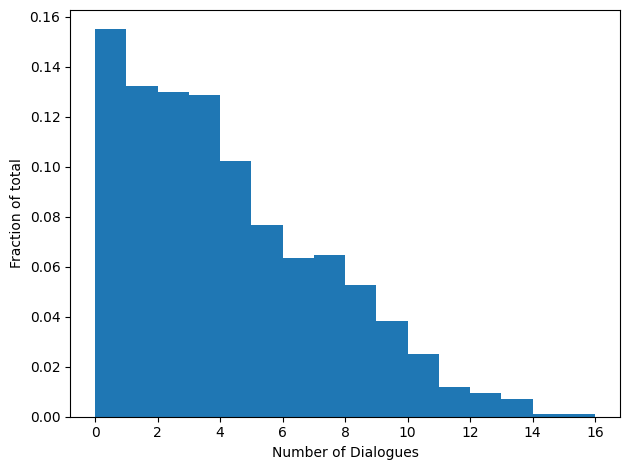

In [ ]:
# Actual plot
plot_len_histogram(unique_lengths, "Number of Dialogues");

### Handle NaNs

In [ ]:
all_vals = list()
for el in raw_dataset:
  for i in range(len(el["triggers"])):
    if el["triggers"][i] != 0 and el["triggers"][i] != 1:
      el["triggers"][i] = 0.0

### Add field for unique dialogues

In [ ]:
# Will set an ID to each dataset entry that is individual to each set of related dialogues

# First, shuffle, because previously listed in the decreasing order of utterance length
# Since we will use these IDs at splitting the data, we don't want any
# underlying bias in the ordering of the samples
random.shuffle(stacked_utterances)

# Iterate through the dataset to find the corresponding ID
for i in range(len(raw_dataset)):
  flat_utterance = " ".join(raw_dataset[i]["utterances"])

  for j, el in enumerate(stacked_utterances):
    if flat_utterance in el:
      raw_dataset[i]["dialogue_id"] = j
      break

# Check on the first 10 samples
for i in range(10):
  for element in raw_dataset[i]:
    print(element, "-", raw_dataset[i][element])
  print()

episode - utterance_0
speakers - ['Chandler', 'The Interviewer', 'Chandler', 'The Interviewer', 'Chandler']
emotions - ['neutral', 'neutral', 'neutral', 'neutral', 'surprise']
utterances - ["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.']
triggers - [0.0, 0.0, 0.0, 1.0, 0.0]
dialogue_id - 139

episode - utterance_1
speakers - ['Chandler', 'The Interviewer', 'Chandler', 'The Interviewer', 'Chandler', 'The Interviewer', 'Chandler']
emotions - ['neutral', 'neutral', 'neutral', 'neutral', 'surprise', 'neutral', 'neutral']
utterances - ["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.', "Now you'll be heading a whole division, so you'll have a l

### Split dataset

We don't take into consideration the number of sub-dialogues in each set of related dialogues because the random split of the data should ensure a similar distribution between the trainining, validation, and testing subsets.

In [ ]:
# Compute the actual size of the 80 - 10 - 10 split
val_size = test_size = int(0.1 * len(stacked_utterances))
train_size = len(stacked_utterances) - val_size - test_size

print(train_size, val_size, test_size)

667 83 83


In [ ]:
# Simple split of the using a list of ids of the groups of dialogues
dialogue_ids = list(range(len(stacked_utterances)))
random.shuffle(dialogue_ids)

train_ids = dialogue_ids[:train_size]
val_ids = dialogue_ids[train_size:train_size + val_size]
test_ids = dialogue_ids[train_size + val_size:]

print(len(train_ids), len(val_ids), len(test_ids))

667 83 83


In [ ]:
# Actual split based on dialogue_id
train_raw = list()
val_raw = list()
test_raw = list()

for el in raw_dataset:
  if el["dialogue_id"] in train_ids:
    train_raw.append(el)
  elif el["dialogue_id"] in val_ids:
    val_raw.append(el)
  else:
    test_raw.append(el)

# Check distribution
print(len(train_raw))
print(len(val_raw))
print(len(test_raw))

3200
412
388


### Analyze data split distribution

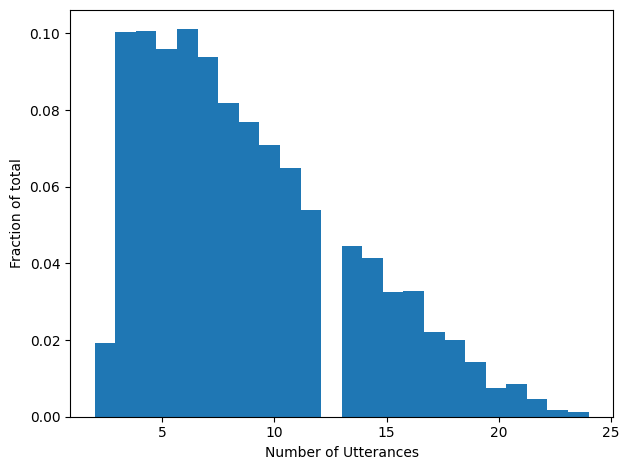

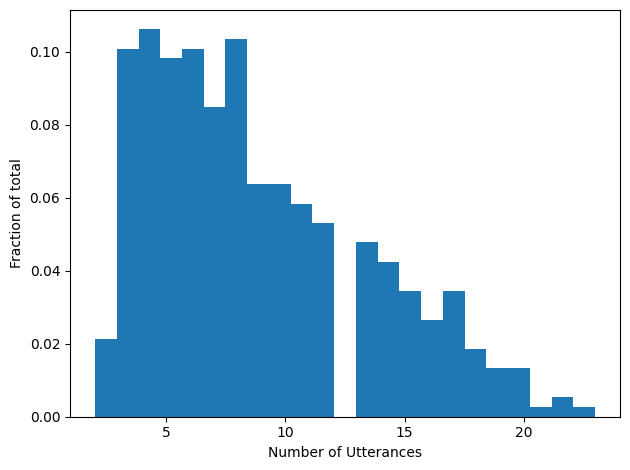

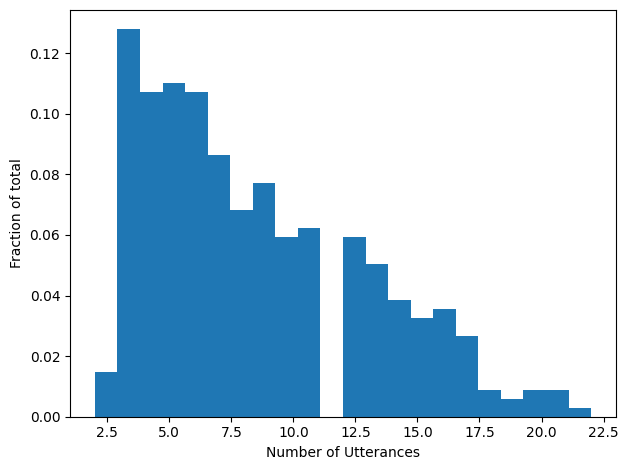

In [ ]:
# Plot the distribution of the utterances lengths separated on each split
train_lengths = list()
val_lengths = list()
test_lengths = list()

for el in train_raw:
  train_lengths.append(len(el["triggers"]))
for el in val_raw:
  val_lengths.append(len(el["triggers"]))
for el in test_raw:
  test_lengths.append(len(el["triggers"]))

plot_len_histogram(train_lengths, "Number of Utterances")
plot_len_histogram(val_lengths, "Number of Utterances")
plot_len_histogram(test_lengths, "Number of Utterances")

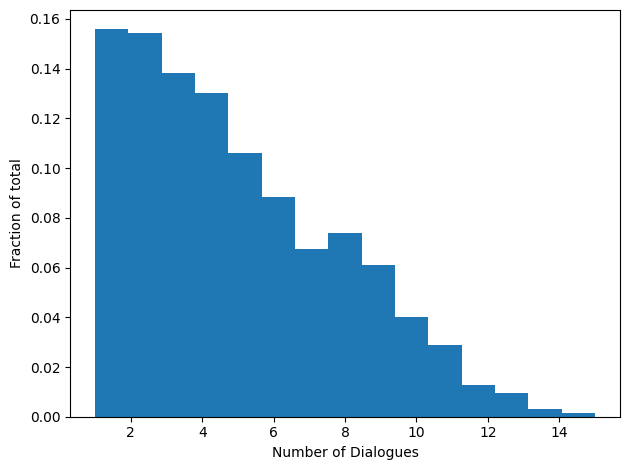

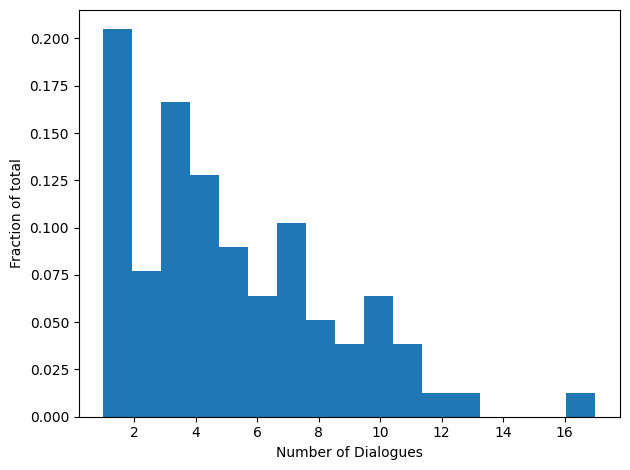

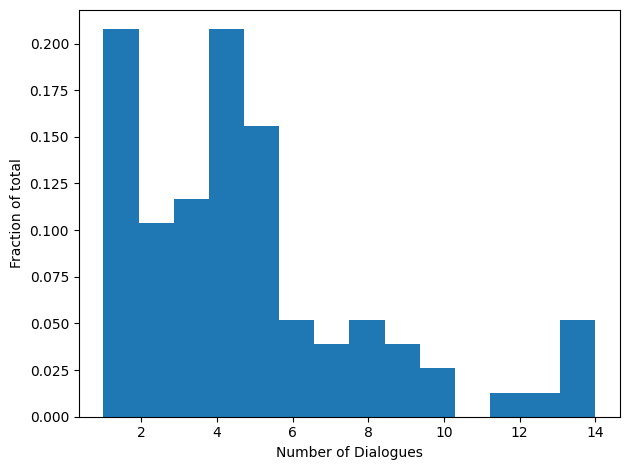

In [ ]:
# Plot the number of sub-dialogues for each dialogue, as before, but separated on splits
train_uniques = dict()
val_uniques = dict()
test_uniques = dict()

for el in train_raw:
  if el["dialogue_id"] in train_uniques.keys():
    train_uniques[el["dialogue_id"]] += 1
  else:
    train_uniques[el["dialogue_id"]] = 1
for el in val_raw:
  if el["dialogue_id"] in val_uniques.keys():
    val_uniques[el["dialogue_id"]] += 1
  else:
    val_uniques[el["dialogue_id"]] = 1
for el in test_raw:
  if el["dialogue_id"] in test_uniques.keys():
    test_uniques[el["dialogue_id"]] += 1
  else:
    test_uniques[el["dialogue_id"]] = 1

plot_len_histogram(train_uniques.values(), "Number of Dialogues")
plot_len_histogram(val_uniques.values(), "Number of Dialogues")
plot_len_histogram(test_uniques.values(), "Number of Dialogues")

### Create DataFrames

In [ ]:
train_df = pd.DataFrame.from_dict(train_raw)
val_df = pd.DataFrame.from_dict(val_raw)
test_df = pd.DataFrame.from_dict(test_raw)

# Print sample
train_df

,episode,speakers,emotions,utterances,triggers,dialogue_id
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]",139
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",139
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",139
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",139
4,utterance_7,"[Chandler, Monica, Chandler]","[neutral, neutral, joy]","[Hey, Mon., Hey-hey-hey. You wanna hear someth...","[0.0, 1.0, 0.0]",775
...,...,...,...,...,...,...
3195,utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",395
3196,utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",395
3197,utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",395
3198,utterance_3998,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",395


Let's check the distribution of both labels (emotions and triggers) in our training set

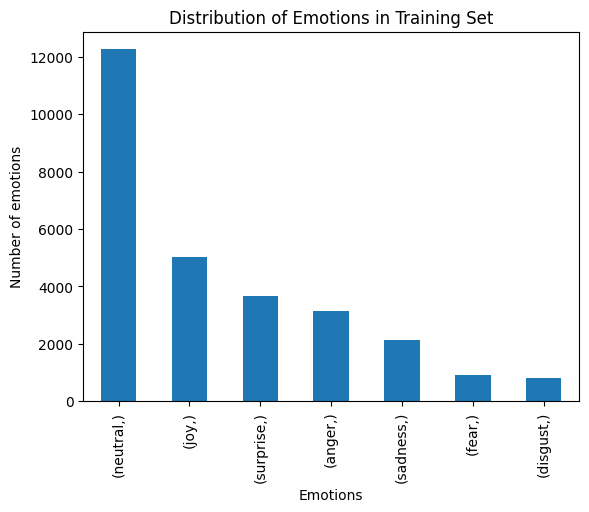

In [ ]:
pd.DataFrame([x for xs in train_df['emotions'] for x in xs]).value_counts().plot(kind='bar')
plt.xlabel("Emotions")
plt.ylabel("Number of emotions")
plt.title("Distribution of Emotions in Training Set")

plt.show()

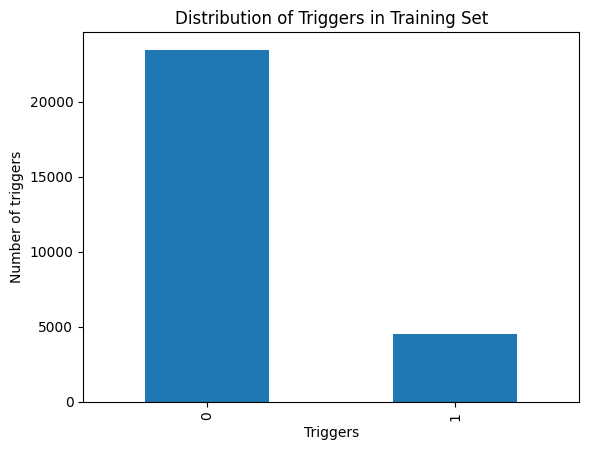

In [ ]:
pd.DataFrame([x for xs in train_df['triggers'] for x in xs]).value_counts().plot(kind='bar')
X_axis = np.arange(2)
plt.xticks(X_axis, {0,1})
plt.xlabel("Triggers")
plt.ylabel("Number of triggers")
plt.title("Distribution of Triggers in Training Set")

plt.show()

In [ ]:
label_encoder = preprocessing.LabelEncoder()

# Flatten the lists
labels = [item for items in train_df['emotions'] for item in items]

# Number of unique classes that is needed to the model
unique_labels = list(set(labels))
num_classes = len(unique_labels)
print(num_classes)

label_encoder.fit(unique_labels)

def to_one_hot(x):
  result = list()
  for el in x:
    current_array = [0.0] * num_classes
    current_array[el] = 1.0
    result += current_array

  return result

7


In [ ]:
train_df['encoded_emotions'] = train_df['emotions'].apply(lambda x: label_encoder.transform(x)).map(to_one_hot)
val_df['encoded_emotions'] = val_df['emotions'].apply(lambda x: label_encoder.transform(x)).map(to_one_hot)
test_df['encoded_emotions'] = test_df['emotions'].apply(lambda x: label_encoder.transform(x)).map(to_one_hot)

test_df

,episode,speakers,emotions,utterances,triggers,dialogue_id,encoded_emotions
0,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]",714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,utterance_5,"[Joey, Rachel, Joey, Rachel, Joey]","[surprise, sadness, surprise, fear, neutral]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 0.0, 1.0, 0.0]",714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,utterance_6,"[Joey, Rachel, Joey, Rachel, Joey, Joey, Rachel]","[surprise, sadness, surprise, fear, neutral, n...",[But then who? The waitress I went out with la...,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]",714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,utterance_37,"[Phoebe, Phoebe, Chandler, Customer, Chandler]","[neutral, neutral, neutral, neutral, joy]","[Yes, and it is my dying wish to have that rin...","[0.0, 0.0, 0.0, 1.0, 0.0]",590,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_76,"[Rachel, Joey, Phoebe, Joey, Joey, Joey, Joey,...","[neutral, joy, joy, joy, joy, joy, joy, joy, n...","[How did it go with Erin?, Oh, unbelievable! W...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",301,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
383,utterance_3966,"[Phoebe, Phoebe, Phoebe, Phoebe, Phoebe, Phoebe]","[neutral, sadness, sadness, sadness, joy, anger]","[It's Phoebe., Umm, well I sorta have some bad...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",226,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
384,utterance_3967,"[Phoebe, Phoebe, Phoebe, Phoebe, Phoebe, Phoeb...","[neutral, sadness, sadness, sadness, joy, ange...","[It's Phoebe., Umm, well I sorta have some bad...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",226,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
385,utterance_3974,"[Ross, Chloe, Ross]","[neutral, sadness, surprise]","[Chloe? Hi.., Is this about me taking your wat...","[0.0, 1.0, 0.0]",221,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
386,utterance_3975,"[Ross, Chloe, Ross, Chloe, Ross]","[neutral, sadness, surprise, sadness, sadness]","[Chloe? Hi.., Is this about me taking your wat...","[0.0, 0.0, 0.0, 1.0, 1.0]",221,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


### Create dataset objects

In [ ]:
x_train = train_df[["utterances", "dialogue_id"]]
x_val = val_df[["utterances", "dialogue_id"]]
x_test = test_df[["utterances", "dialogue_id"]]

y_train = train_df[["triggers", "encoded_emotions"]]
y_val = val_df[["triggers", "encoded_emotions"]]
y_test = test_df[["triggers", "encoded_emotions"]]

In [ ]:
y_test

,triggers,encoded_emotions
0,"[0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
383,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
384,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
385,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
386,"[0.0, 0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


##Metrics

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
def sequence_f1(data, predictions, labels, optimal_threshold):
  scores_emotions = []
  scores_triggers = []
  unique_dialogs = list({value:"" for value in data['dialogue_id']})
  i=0
  for dialog_id in unique_dialogs:
      num_concat = len(data[data['dialogue_id'] == dialog_id])

      y_true_tri = np.concatenate(labels[0][i:i+num_concat])
      y_pred_tri = np.concatenate(predictions[:, :24][i:i+num_concat])

      y_pred_tri = y_pred_tri[y_true_tri != -1]
      y_true_tri = y_true_tri[y_true_tri != -1]

      y_pred_tri[y_pred_tri <=  optimal_threshold] = 0
      y_pred_tri[y_pred_tri >  optimal_threshold] = 1

      scores_triggers.append(f1_score(y_true_tri, y_pred_tri, average='micro'))

      y_true_emo = np.concatenate(labels[1][i:i+num_concat])
      y_pred_emo = np.concatenate(predictions[:, 24:][i:i+num_concat])

      y_pred_emo = y_pred_emo[y_true_emo != -1]
      y_true_emo = y_true_emo[y_true_emo != -1]

      y_pred_emo = y_pred_emo.reshape(int(len(y_pred_emo)/num_classes),num_classes)
      y_true_emo = y_true_emo.reshape(int(len(y_true_emo)/num_classes),num_classes)

      scores_emotions.append(f1_score(np.argmax(y_true_emo, axis=1), np.argmax(y_pred_emo, axis=1), average='micro'))
      i += num_concat

  return scores_triggers, scores_emotions


In [ ]:
def unrolled_f1(predictions, labels, optimal_threshold):

  y_true_tri = np.concatenate(labels[0])
  # y_pred_tri = np.concatenate(predictions[0])
  y_pred_tri = np.concatenate(predictions[:, :24])

  y_pred_tri = y_pred_tri[y_true_tri != -1]
  y_true_tri = y_true_tri[y_true_tri != -1]

  y_pred_tri[y_pred_tri <=  optimal_threshold] = 0
  y_pred_tri[y_pred_tri >  optimal_threshold] = 1

  score_triggers = f1_score(y_true_tri, y_pred_tri, average='micro')

  y_true_emo = np.concatenate(labels[1])
  # y_pred_emo = np.concatenate(predictions[1])
  y_pred_emo = np.concatenate(predictions[:, 24:])

  y_pred_emo = y_pred_emo[y_true_emo != -1]
  y_true_emo = y_true_emo[y_true_emo != -1]

  y_pred_emo = y_pred_emo.reshape(int(len(y_pred_emo)/num_classes),num_classes)
  y_true_emo = y_true_emo.reshape(int(len(y_true_emo)/num_classes),num_classes)

  score_emotions = f1_score(np.argmax(y_true_emo, axis=1), np.argmax(y_pred_emo, axis=1), average='micro')

  return score_triggers, score_emotions


## Model definition

### Baselines

#### Baseline 1
Random uniform classifier (individual classifier per category)

In [ ]:
baseline_1 = DummyClassifier(strategy="uniform")

#### Baseline 2
Majority classifier (individual classifier per category)

In [ ]:
baseline_2_triggers = DummyClassifier(strategy="most_frequent")
baseline_2_emotions = DummyClassifier(strategy="most_frequent")

### Preliminaries

In [ ]:
model_card = 'bert-base-uncased'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_card)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess(df, tokenizer):
  # Use dict format for easy transformation into DataFrame later
  encoding = dict()

  # Iterate through each dataset entry
  for i in range(len(df)):
    # Tokenize
    tokenizer_result = tokenizer(df["utterances"][i])

    # Append to encoding dictionary
    for key in tokenizer_result.keys():
      # Add key to dict (will happen only once, for the first entry of the set)
      if key not in encoding.keys():
        encoding[key] = list()

      # Create a list in the dict for the current entry
      # and add the first utterance as is
      encoding[key].append(tokenizer_result[key][0])

      # Add the rest of the utterances by removing the first (starting) token
      for j in range(1, len(tokenizer_result[key])):
        encoding[key][i] += tokenizer_result[key][j][1:]

  # Transform encoding into DataFrame and concatenate it to the existing one
  encoding_df = pd.DataFrame.from_dict(encoding)
  return df.join(encoding_df)

In [ ]:
# Perform preprocessing
x_train_processed = preprocess(x_train, tokenizer)
x_val_processed = preprocess(x_val, tokenizer)
x_test_processed = preprocess(x_test, tokenizer)

In [ ]:
# Print demo sentences
def demo_sentence_print(df, tokenizer):
  print("Original sentences")

  print(df["utterances"][50])

  print("\nTokenization result")
  print(df['input_ids'][50])
  print(df['attention_mask'][50])

  print("\nDecoded sentence")
  print(tokenizer.decode(df['input_ids'][50]))

demo_sentence_print(x_test_processed, tokenizer)

Original sentences
["Hi Joey it's Jane Rogers, can't wait    for your party tonight.", 'Listen, I forgot your address, can you give me a call?', 'Thanks, bye.', 'Hey!', 'Hey!', "What's happening?", "Yeah, it's a real shame you can't make it to that one-woman    show tonight.", "Oh, I'd love to, but I gotta get up so early the next day and    so, you know me, work comes first", 'Oh, yeah, yeah, yeah...', '"Hi Joey, it\'s Jane Rogers can\'t wait for your party tonight"', 'Stupid Jane Rogers!!', 'You are having a party tonight??', "Kinda have a... a thing for the Days Of Our Life's people.", "And you weren't going to tell us? How did you think you were    gonna get away with that?", 'I do it every year.', 'You do that every year??', "I didn't have to tell you that!! I'm stupider than Jane Rogers!!", "Oh, that's why you got these tickets to that play, to get rid    of us??"]

Tokenization result
[101, 7632, 9558, 2009, 1005, 1055, 4869, 7369, 1010, 2064, 1005, 1056, 3524, 2005, 2115, 2283,

In [ ]:
# Compute max length of a dialogue
max_len = max(
    x_train["utterances"].str.len().max(),
    x_val["utterances"].str.len().max(),
    x_test["utterances"].str.len().max())

print(max_len)

24


In [ ]:
# Pad data to maximum length of a dialogue
def pad_data(x, target_length, padding_value):
  return x + (target_length - len(x)) * [padding_value]

# Function to apply all required padding on a DataFrame
def apply_all_padding(y_df, max_len, num_classes):
  y_df["triggers"] = y_df["triggers"].apply(pad_data, args=(max_len, -1))
  y_df["encoded_emotions"] = y_df["encoded_emotions"].map(list).apply(pad_data, args=(max_len * num_classes, -1))

In [ ]:
# Apply padding to all subsets
apply_all_padding(y_train, max_len, num_classes)
apply_all_padding(y_val, max_len, num_classes)
apply_all_padding(y_test, max_len, num_classes)

<ipython-input-29-ff12f12a6ae6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df["triggers"] = y_df["triggers"].apply(pad_data, args=(max_len, -1))
<ipython-input-29-ff12f12a6ae6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df["encoded_emotions"] = y_df["encoded_emotions"].map(list).apply(pad_data, args=(max_len * num_classes, -1))


In [ ]:
# Transform into Dataset object
train_data = Dataset.from_pandas(pd.concat([x_train_processed, y_train], axis=1))
val_data = Dataset.from_pandas(pd.concat([x_val_processed, y_val], axis=1))
test_data = Dataset.from_pandas(pd.concat([x_test_processed, y_test], axis=1))

In [ ]:
# Dimension check
print(test_data)
print(test_data[0])
print(len(test_data[0]["triggers"]))

Dataset({
    features: ['utterances', 'dialogue_id', 'input_ids', 'token_type_ids', 'attention_mask', 'triggers', 'encoded_emotions'],
    num_rows: 388
})
{'utterances': ['But then who? The waitress I went out with last month?', 'You know? Forget it!', 'No-no-no-no, no! Who, who were you talking about?', "No, I-I-I-I don't, I actually don't know"], 'dialogue_id': 714, 'input_ids': [101, 2021, 2059, 2040, 1029, 1996, 13877, 1045, 2253, 2041, 2007, 2197, 3204, 1029, 102, 2017, 2113, 1029, 5293, 2009, 999, 102, 2053, 1011, 2053, 1011, 2053, 1011, 2053, 1010, 2053, 999, 2040, 1010, 2040, 2020, 2017, 3331, 2055, 1029, 102, 2053, 1010, 1045, 1011, 1045, 1011, 1045, 1011, 1045, 2123, 1005, 1056, 1010, 1045, 2941, 2123, 1005, 1056, 2113, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
data_collator = Collator(tokenizer=tokenizer)

### BERT Custom Model

In [ ]:
class CustomBertMLC(BertPreTrainedModel):
  def __init__(self, config, **kwargs):
        super().__init__(config)
        self.num_labels = kwargs.get("task_labels_map", {})
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)

        self.classifier1 = nn.Linear(
            config.hidden_size, list(self.num_labels.values())[0]
        )

        self.classifier2 = nn.Linear(
            config.hidden_size, list(self.num_labels.values())[1]
        )

        self.sigmoid = nn.Sigmoid()

        # Initialize weights and apply final processing
        self.post_init()

  def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        triggers: Optional[torch.Tensor] = None,
        encoded_emotions: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cat_feats: Optional[torch.Tensor] = None
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = self.dropout(outputs[1])

        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)

        logits1 = self.sigmoid(logits1)
        logits2 = self.sigmoid(logits2)

        loss_fct = nn.BCEWithLogitsLoss()

        if triggers is not None:
            mask = (triggers != -1).float()
            loss1 = loss_fct(logits1, triggers)
            loss1 = (loss1 * mask).sum() / mask.sum()

        if encoded_emotions is not None:
            mask = (encoded_emotions != -1).float()
            loss2 = loss_fct(logits2, encoded_emotions)
            loss2 = (loss2 * mask).sum() / mask.sum()

        loss = loss1 + loss2

        return SequenceClassifierOutput(
            loss=loss,
            logits=torch.cat([logits1, logits2], dim=1),
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [ ]:
model = CustomBertMLC.from_pretrained(
    model_card,
    task_labels_map={"triggers": max_len, "encoded_emotions": num_classes*max_len},
    problem_type="multi_label_classification"
)

print(model)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier2.bias', 'classifier1.bias', 'classifier1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomBertMLC(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

##Training and Evaluation

### Baselines
The training process of these ones consists only in passing the labels, such that the model will set the output when called, based on the initial given strategy. The X part of the data is actually ignored.

#### Baseline 1
Random uniform classifier

In [ ]:
# "Fit" to activate random uniform classification on predict call
baseline_1.fit(
    X=None,
    y=y_train,
);

In [ ]:
# Perform evaluation
test_predictions_base1 = baseline_1.predict(x_test)
test_labels_base1 = y_test

# Set thresh to 0.5 since output only consists of 0 and 1 values
optimal_threshold_base1=0.5

# Assuming test_predictions_base1 is your input data
triggers_predictions_list = [sublist[0] for sublist in test_predictions_base1]
emotions_predictions_list = [sublist[1] for sublist in test_predictions_base1]

# Convert the lists to numpy arrays
triggers_predictions = np.array(triggers_predictions_list)
emotions_predictions = np.array(emotions_predictions_list)

# Now predictions[0] corresponds to trigger predictions, and predictions[1] corresponds to emotion predictions
predictions_b1 = [triggers_predictions, emotions_predictions]

triggers_array = np.array(test_labels_base1['triggers'].tolist())
emotions_array = np.array(test_labels_base1['encoded_emotions'].tolist())
labels_b1 = [triggers_array,emotions_array]

# Evaluate sequence F1
trigger_f1_seq_base1_arr, emotion_f1_seq_base1_arr = sequence_f1(
    test_df,
    np.concatenate([predictions_b1[0], predictions_b1[1]], axis=1),
    labels_b1,
    optimal_threshold_base1)

trigger_f1_seq_base1 = np.mean(trigger_f1_seq_base1_arr)
emotion_f1_seq_base1 = np.mean(emotion_f1_seq_base1_arr)

print(f"Sequence F1 score for triggers: {trigger_f1_seq_base1} and for emotions: {emotion_f1_seq_base1}")

# Evaluate unrolled F1
trigger_f1_unrol_base1, emotion_f1_unrol_base1 = unrolled_f1(
    np.concatenate([predictions_b1[0], predictions_b1[1]], axis=1),
    labels_b1,
    optimal_threshold_base1)

print(f"Unrolled F1 score for triggers: {trigger_f1_unrol_base1} and for emotions: {emotion_f1_unrol_base1}")

Sequence F1 score for triggers: 0.7125613963465726 and for emotions: 0.23329296656955986
Unrolled F1 score for triggers: 0.7285917496443812 and for emotions: 0.21422475106685632


#### Baseline 2
Majority classifier

In [ ]:
# "Fit" to activate majority classification on predict call
baseline_2_triggers.fit(
    X=None,
    y=y_train['triggers'],
);
baseline_2_emotions.fit(
    X=None,
    y=y_train['encoded_emotions'],
);

In [ ]:
# Perform evaluation
test_predictions_base2_tri = baseline_2_triggers.predict(x_test)
test_predictions_base2_emo = baseline_2_emotions.predict(x_test)
test_labels_base2 = y_test

# Set thresh to 0.5 since output only consists of 0 and 1 values
optimal_threshold_base2=0.5

# Assuming test_predictions_base2 is your input data
triggers_predictions_list = test_predictions_base2_tri.reshape(int(len(test_predictions_base2_tri)/max_len),max_len)
emotions_predictions_list = test_predictions_base2_emo.reshape(int(len(test_predictions_base2_emo)/(max_len*len(unique_labels))),max_len*len(unique_labels))

# Convert the lists to numpy arrays
triggers_predictions_base2 = np.array(triggers_predictions_list)
emotions_predictions_base2 = np.array(emotions_predictions_list)

# Now predictions[0] corresponds to trigger predictions, and predictions[1] corresponds to emotion predictions
predictions_b2 = [triggers_predictions_base2, emotions_predictions_base2]

triggers_array = np.array(test_labels_base2['triggers'].tolist())
emotions_array = np.array(test_labels_base2['encoded_emotions'].tolist())
labels_b2 = [triggers_array,emotions_array]

# Print sequence F1
trigger_f1_seq_base2_arr, emotion_f1_seq_base2_arr = sequence_f1(
    test_df,
    np.concatenate([predictions_b2[0], predictions_b2[1]], axis=1),
    labels_b2,
    optimal_threshold_base2)

trigger_f1_seq_base2 = np.mean(trigger_f1_seq_base2_arr)
emotion_f1_seq_base2 = np.mean(emotion_f1_seq_base2_arr)

print(f"Sequence F1 score for triggers: {trigger_f1_seq_base2} and for emotions: {emotion_f1_seq_base2}")

# Print unrolled F1
trigger_f1_unrol_base2, emotion_f1_unrol_base2 = unrolled_f1(
    np.concatenate([predictions_b2[0], predictions_b2[1]], axis=1),
    labels_b2,
    optimal_threshold_base2)

print(f"Unrolled F1 score for triggers: {trigger_f1_unrol_base2} and for emotions: {emotion_f1_unrol_base2}")

Sequence F1 score for triggers: 0.7223743058025247 and for emotions: 0.2523602193243866
Unrolled F1 score for triggers: 0.7601706970128023 and for emotions: 0.1965860597439545


###Bert Baseline Frozen

Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier2.bias', 'classifier1.bias', 'classifier1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.402900,1.401521
2,1.389300,1.394558
3,1.387300,1.393492
4,1.386600,1.393267
5,1.386500,1.393208
6,1.386500,1.393066
7,1.386400,1.393006
8,1.386700,1.392953
9,1.386400,1.392917
10,1.386400,1.392894


Bert Baseline Freezed ROC Curve

AUC-ROC score for Triggers is: 0.49883946498625403
Threshold value for Triggers is: 2.5133138e-05


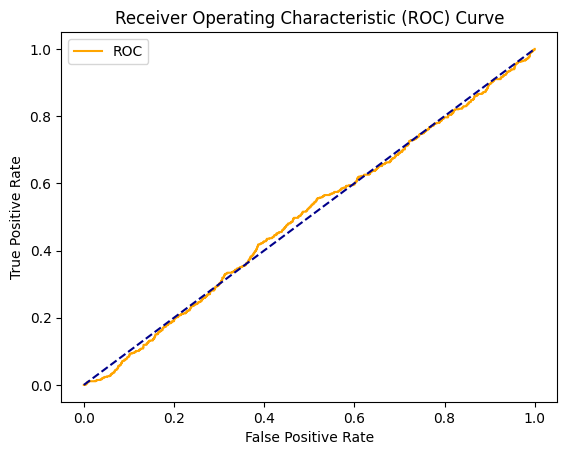

Sequence F1 score for triggers: 0.4987931258300046 and for emotions: 0.4675933173126218
Unrolled F1 score for triggers: 0.49274537695590326 and for emotions: 0.4122332859174964


Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier2.bias', 'classifier1.bias', 'classifier1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.403700,1.401579
2,1.389400,1.394611
3,1.386900,1.393550
4,1.387700,1.393293
5,1.386500,1.393214
6,1.386500,1.393173
7,1.386600,1.393085
8,1.386400,1.393035
9,1.386400,1.393002
10,1.386600,1.393002


Bert Baseline Freezed ROC Curve

AUC-ROC score for Triggers is: 0.49526117443548645
Threshold value for Triggers is: 3.108451e-05


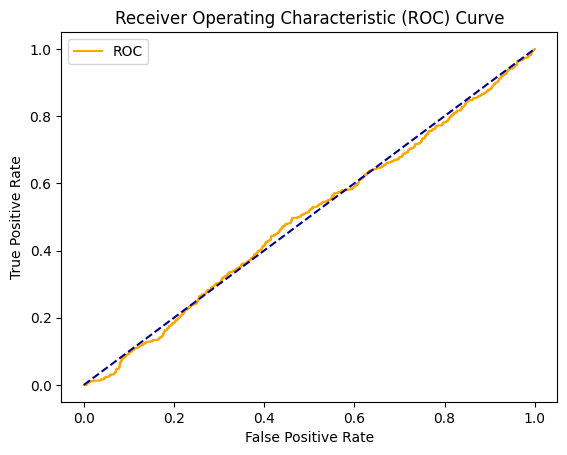

Sequence F1 score for triggers: 0.532705450803486 and for emotions: 0.45820155721531325
Unrolled F1 score for triggers: 0.5308677098150782 and for emotions: 0.3985775248933144


Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier2.bias', 'classifier1.bias', 'classifier1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.406400,1.401689
2,1.392500,1.394598
3,1.387200,1.393567
4,1.386700,1.393254
5,1.386500,1.393128
6,1.387200,1.393006
7,1.386400,1.392883
8,1.386400,1.392867
9,1.386400,1.392848
10,1.386400,1.392845


Bert Baseline Freezed ROC Curve

AUC-ROC score for Triggers is: 0.4938627868903099
Threshold value for Triggers is: 2.6826834e-05


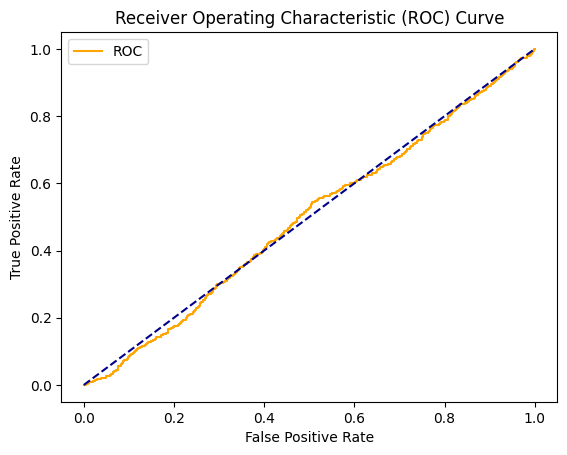

Sequence F1 score for triggers: 0.5037152015526567 and for emotions: 0.46975006230799815
Unrolled F1 score for triggers: 0.5007112375533428 and for emotions: 0.41450924608819345


Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier2.bias', 'classifier1.bias', 'classifier1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.403800,1.401539
2,1.389800,1.394504
3,1.389700,1.393357
4,1.386900,1.393065
5,1.389100,1.392914
6,1.386900,1.392904
7,1.386500,1.392840
8,1.386400,1.392808
9,1.386400,1.392772
10,1.387200,1.392764


Bert Baseline Freezed ROC Curve

AUC-ROC score for Triggers is: 0.5098196027553825
Threshold value for Triggers is: 3.7622092e-05


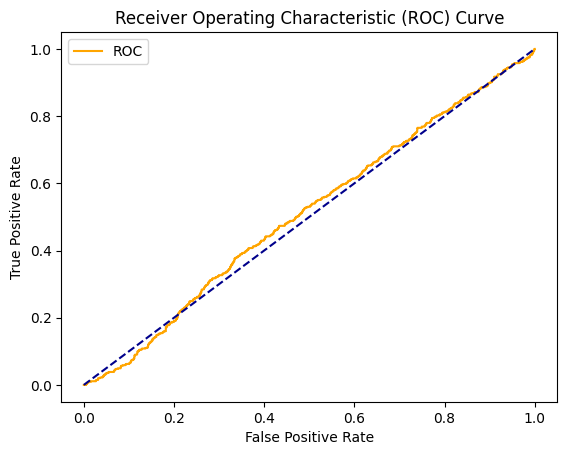

Sequence F1 score for triggers: 0.5990302947441316 and for emotions: 0.44531075514135315
Unrolled F1 score for triggers: 0.6119487908961593 and for emotions: 0.3817923186344239


Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier2.bias', 'classifier1.bias', 'classifier1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.407200,1.401513
2,1.389500,1.394571
3,1.391400,1.393509
4,1.386700,1.393247
5,1.388000,1.393131
6,1.386500,1.392989
7,1.386500,1.392922
8,1.386900,1.392874
9,1.386900,1.392843
10,1.386400,1.392837


Epoch,Training Loss,Validation Loss
1,1.407200,1.401513
2,1.389500,1.394571
3,1.391400,1.393509
4,1.386700,1.393247
5,1.388000,1.393131
6,1.386500,1.392989
7,1.386500,1.392922
8,1.386900,1.392874
9,1.386900,1.392843
10,1.386400,1.392837


Bert Baseline Freezed ROC Curve

AUC-ROC score for Triggers is: 0.49923053161585274
Threshold value for Triggers is: 3.101969e-05


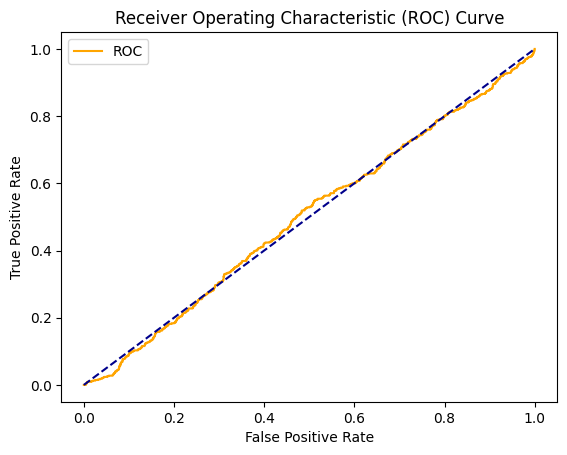

Sequence F1 score for triggers: 0.5058383063834099 and for emotions: 0.47466894113710256
Unrolled F1 score for triggers: 0.4975817923186344 and for emotions: 0.42105263157894735


In [ ]:
seeds = [1,29,387,4654,53210]
models_freeze = {}
trigger_seq_f1_freeze_dict = {}
emotion_seq_f1_freeze_dict = {}
trigger_unrol_f1_freeze_dict = {}
emotion_unrol_f1_freeze_dict = {}

for seed in seeds:
    # Set seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Training arguments
    training_args_freeze = TrainingArguments(
        output_dir="test_freeze_dir",                 # where to save model
        label_names=["triggers","encoded_emotions"],
        #logging_steps = 100,
        learning_rate=2e-5,
        per_device_train_batch_size=1,         # accelerate defines distributed training
        per_device_eval_batch_size=1,
        num_train_epochs=10,
        weight_decay=0.01,
        evaluation_strategy="epoch",           # when to report evaluation metrics/losses
        save_strategy="epoch",                 # when to save checkpoint
        load_best_model_at_end=True,
        report_to='none',                       # disabling wandb (default)
        seed=seed
    )

    # Create model (to reset previously trained one)
    model = CustomBertMLC.from_pretrained(
        model_card,
        task_labels_map={"triggers": max_len, "encoded_emotions": num_classes*max_len},
        problem_type="multi_label_classification"
    )

    # Freeze its parameters
    for param in model.bert.parameters():
      param.requires_grad = False

    # Train
    trainer_freezed = Trainer(
        model=model,
        args=training_args_freeze,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        data_collator=data_collator
        )

    trainer_freezed.train()

    models_freeze[seed]=trainer_freezed

    test_prediction_info_freezed = trainer_freezed.predict(test_data)
    test_predictions_freezed = test_prediction_info_freezed.predictions
    test_labels_freezed = test_prediction_info_freezed.label_ids

    print("Bert Baseline Freezed ROC Curve")
    y_true_freezed = test_labels_freezed[0].flatten()
    y_scores_freezed = test_predictions_freezed[:, :24].flatten()

    fpr, tpr, thresholds = roc_curve(y_true_freezed[y_true_freezed != -1], y_scores_freezed[y_true_freezed != -1])
    print()
    print("AUC-ROC score for Triggers is:", roc_auc_score(y_true_freezed[y_true_freezed != -1], y_scores_freezed[y_true_freezed != -1]))

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_freezed = thresholds[optimal_idx]
    print("Threshold value for Triggers is:", optimal_threshold_freezed)

    plot_roc_curve(fpr, tpr)

    trigger_f1_seq_freez_arr, emotion_f1_seq_freez_arr = sequence_f1(test_df, test_prediction_info_freezed.predictions, test_prediction_info_freezed.label_ids, optimal_threshold_freezed)
    trigger_f1_seq_freez = np.mean(trigger_f1_seq_freez_arr)
    emotion_f1_seq_freez = np.mean(emotion_f1_seq_freez_arr)
    print(f"Sequence F1 score for triggers: {trigger_f1_seq_freez} and for emotions: {emotion_f1_seq_freez}")

    trigger_seq_f1_freeze_dict[seed]=trigger_f1_seq_freez
    emotion_seq_f1_freeze_dict[seed]=emotion_f1_seq_freez

    trigger_f1_unrol_freez, emotion_f1_unrol_freez = unrolled_f1(test_prediction_info_freezed.predictions, test_prediction_info_freezed.label_ids, optimal_threshold_freezed)
    print(f"Unrolled F1 score for triggers: {trigger_f1_unrol_freez} and for emotions: {emotion_f1_unrol_freez}")

    trigger_unrol_f1_freeze_dict[seed]=trigger_f1_unrol_freez
    emotion_unrol_f1_freeze_dict[seed]=emotion_f1_unrol_freez

### Bert Baseline Full

Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier1.weight', 'classifier1.bias', 'classifier2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.387900,1.387455
2,1.386600,1.386494
3,1.386300,1.386340
4,1.386300,1.386306
5,1.386300,1.386298
6,1.386300,1.386296
7,1.386300,1.386295
8,1.386300,1.386295
9,1.386300,1.386295
10,1.386300,1.386295


Bert Baseline Full ROC Curve

AUC-ROC score for Triggers is: 0.41727581626664195
Threshold value for Triggers is: 1.2404725e-07


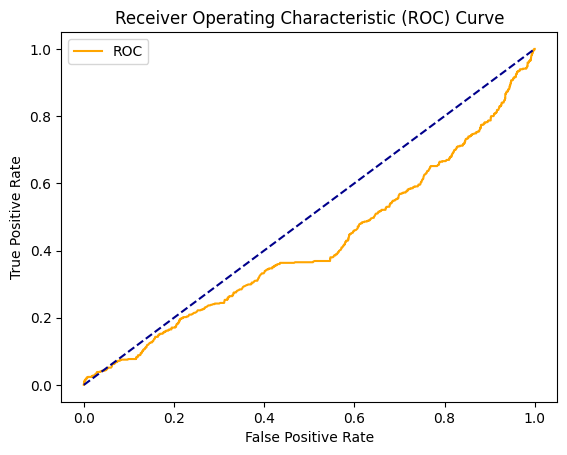

Sequence F1 score for triggers: 0.7873972071049407 and for emotions: 0.45240948474690695
Unrolled F1 score for triggers: 0.842958748221906 and for emotions: 0.3829302987197724


Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier1.weight', 'classifier1.bias', 'classifier2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.388100,1.387565
2,1.386600,1.386512
3,1.386300,1.386344
4,1.386300,1.386307
5,1.386300,1.386298
6,1.386300,1.386296
7,1.386300,1.386295
8,1.386300,1.386295
9,1.386300,1.386295
10,1.386300,1.386295


Bert Baseline Full ROC Curve

AUC-ROC score for Triggers is: 0.4188045593550181
Threshold value for Triggers is: 5.685779e-08


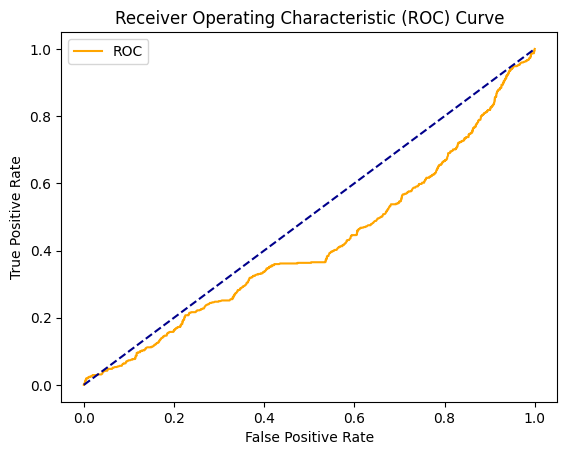

Sequence F1 score for triggers: 0.7892167312996461 and for emotions: 0.4678312074026606
Unrolled F1 score for triggers: 0.842958748221906 and for emotions: 0.41507823613086775


Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier1.weight', 'classifier1.bias', 'classifier2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.388000,1.387517
2,1.386600,1.386504
3,1.386300,1.386341
4,1.386300,1.386306
5,1.386300,1.386298
6,1.386300,1.386295
7,1.386300,1.386295
8,1.386300,1.386295
9,1.386300,1.386295
10,1.386300,1.386295


Bert Baseline Full ROC Curve

AUC-ROC score for Triggers is: 0.4303987891143855
Threshold value for Triggers is: 1.3083384e-07


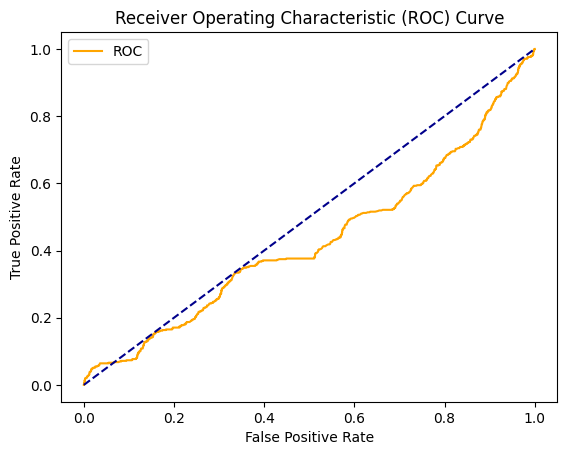

Sequence F1 score for triggers: 0.7720045736172577 and for emotions: 0.4425019150520868
Unrolled F1 score for triggers: 0.8381223328591749 and for emotions: 0.379800853485064


Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier1.weight', 'classifier1.bias', 'classifier2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.387900,1.387421
2,1.386600,1.386487
3,1.386300,1.386338
4,1.386300,1.386305
5,1.386300,1.386297
6,1.386300,1.386296
7,1.386300,1.386295
8,1.386300,1.386295
9,1.386300,1.386295
10,1.386300,1.386295


Bert Baseline Full ROC Curve

AUC-ROC score for Triggers is: 0.4160000617798783
Threshold value for Triggers is: 3.188843e-08


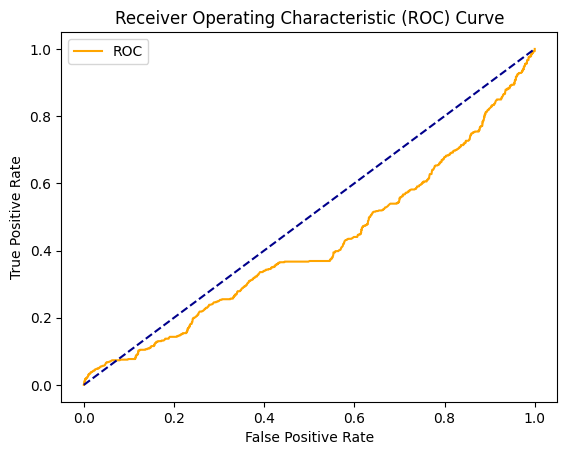

Sequence F1 score for triggers: 0.7717736598458178 and for emotions: 0.47417307534105807
Unrolled F1 score for triggers: 0.8375533428165007 and for emotions: 0.4267425320056899


Some weights of CustomBertMLC were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier2.weight', 'classifier1.weight', 'classifier1.bias', 'classifier2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.388000,1.387537
2,1.386600,1.386506
3,1.386300,1.386342
4,1.386300,1.386306
5,1.386300,1.386298
6,1.386300,1.386295
7,1.386300,1.386295
8,1.386300,1.386295
9,1.386300,1.386295
10,1.386300,1.386295


Bert Baseline Full ROC Curve

AUC-ROC score for Triggers is: 0.41455626602415596
Threshold value for Triggers is: 3.5891986e-08


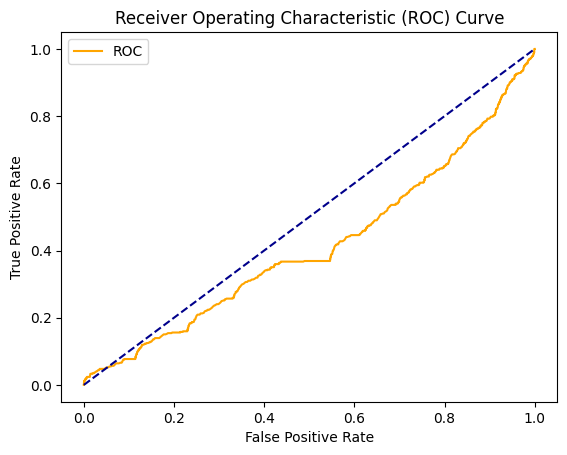

Sequence F1 score for triggers: 0.773477886501146 and for emotions: 0.4724658063441451
Unrolled F1 score for triggers: 0.8375533428165007 and for emotions: 0.4176386913229018


In [ ]:
seeds = [1,29,387,4654,53210]
models_full = {}
trigger_seq_f1_full_dict = {}
emotion_seq_f1_full_dict = {}
trigger_unrol_f1_full_dict = {}
emotion_unrol_f1_full_dict = {}

for seed in seeds:
    # Create model (to reset previously trained one)
    model = CustomBertMLC.from_pretrained(
        model_card,
        task_labels_map={"triggers": max_len, "encoded_emotions": num_classes*max_len},
        problem_type="multi_label_classification"
    )

    # Set seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Training args
    training_args = TrainingArguments(
      output_dir="test_dir",                 # where to save model
      label_names=["triggers","encoded_emotions"],
      #logging_steps = 100,
      learning_rate=2e-5,
      per_device_train_batch_size=1,         # accelerate defines distributed training
      per_device_eval_batch_size=1,
      num_train_epochs=10,
      weight_decay=0.01,
      evaluation_strategy="epoch",           # when to report evaluation metrics/losses
      save_strategy="epoch",                 # when to save checkpoint
      load_best_model_at_end=True,
      report_to='none',                       # disabling wandb (default)
      seed=seed
    )

    # Train
    trainer_full = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        data_collator=data_collator
        )

    trainer_full.train()

    models_full[seed]=trainer_full

    test_prediction_info_full = trainer_full.predict(test_data)
    test_predictions_full = test_prediction_info_full.predictions
    test_labels_full = test_prediction_info_full.label_ids

    print("Bert Baseline Full ROC Curve")
    y_true_full = test_labels_full[0].flatten()
    y_scores_full = test_predictions_full[:, :24].flatten()

    fpr, tpr, thresholds = roc_curve(y_true_full[y_true_full != -1], y_scores_full[y_true_full != -1])
    print()
    print("AUC-ROC score for Triggers is:", roc_auc_score(y_true_full[y_true_full != -1], y_scores_full[y_true_full != -1]))

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_full = thresholds[optimal_idx]
    print("Threshold value for Triggers is:", optimal_threshold_full)

    plot_roc_curve(fpr, tpr)

    trigger_f1_seq_full_arr, emotion_f1_seq_full_arr = sequence_f1(test_df, test_prediction_info_full.predictions, test_prediction_info_full.label_ids, optimal_threshold_full)
    trigger_f1_seq_full = np.mean(trigger_f1_seq_full_arr)
    emotion_f1_seq_full = np.mean(emotion_f1_seq_full_arr)
    print(f"Sequence F1 score for triggers: {trigger_f1_seq_full} and for emotions: {emotion_f1_seq_full}")

    trigger_seq_f1_full_dict[seed]=trigger_f1_seq_full
    emotion_seq_f1_full_dict[seed]=emotion_f1_seq_full

    trigger_f1_unrol_full, emotion_f1_unrol_full = unrolled_f1(test_prediction_info_full.predictions, test_prediction_info_full.label_ids, optimal_threshold_full)
    print(f"Unrolled F1 score for triggers: {trigger_f1_unrol_full} and for emotions: {emotion_f1_unrol_full}")

    trigger_unrol_f1_full_dict[seed]=trigger_f1_unrol_full
    emotion_unrol_f1_full_dict[seed]=emotion_f1_unrol_full

### Checkpoint save

In [ ]:
checkpoints_folder = 'best_checkpoints'
checkpoints_path = os.path.join(os.getcwd(), checkpoints_folder)

if not os.path.exists(checkpoints_path):
    os.mkdir(checkpoints_path)

freezed_path = os.path.join(checkpoints_path, 'bert_freezed')
full_path = os.path.join(checkpoints_path, 'bert_full')


if not os.path.exists(freezed_path):
    os.mkdir(freezed_path)

if not os.path.exists(full_path):
    os.mkdir(full_path)

In [ ]:
#trainer_freezed.save_model(output_dir = freezed_path)
trainer_full.save_model(output_dir = full_path)

!zip -r /content/best_checkpoints.zip /content/best_checkpoints

  adding: content/best_checkpoints/ (stored 0%)
  adding: content/best_checkpoints/bert_freezed/ (stored 0%)
  adding: content/best_checkpoints/bert_full/ (stored 0%)
  adding: content/best_checkpoints/bert_full/special_tokens_map.json (deflated 42%)
  adding: content/best_checkpoints/bert_full/model.safetensors (deflated 7%)
  adding: content/best_checkpoints/bert_full/config.json (deflated 49%)
  adding: content/best_checkpoints/bert_full/tokenizer.json (deflated 71%)
  adding: content/best_checkpoints/bert_full/vocab.txt (deflated 53%)
  adding: content/best_checkpoints/bert_full/tokenizer_config.json (deflated 76%)
  adding: content/best_checkpoints/bert_full/training_args.bin (deflated 51%)


In [ ]:
from google.colab import files

files.download('best_checkpoints.zip')

##Load model from checkpoint

In [ ]:
def get_direct_download_link(gdrive_link):
    # Extract the file ID from the Google Drive sharing link
    file_id = gdrive_link.split("/d/")[1].split("/view")[0]

    # Construct the direct download link
    direct_link = f"https://drive.google.com/uc?id={file_id}"

    return direct_link

In [ ]:
gdrive_link = "https://drive.google.com/file/d/18PIURoiZgFtnK66sLPtgh3zjXEWvDJPc/view?usp=sharing"
direct_download_link = get_direct_download_link(gdrive_link)
print(direct_download_link)

https://drive.google.com/uc?id=18PIURoiZgFtnK66sLPtgh3zjXEWvDJPc


In [ ]:
import gdown
from transformers import BertForSequenceClassification
import zipfile


bert_download = "models_checkpoint"

# Download the checkpoint files using gdown
gdown.download(direct_download_link , bert_download, quiet=False)

# Define the directory where you want to extract the contents
extract_dir = 'model_pre'
# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(bert_download, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


# Define the file paths for downloaded checkpoint files
bert_freezed_path = extract_dir + '/content/best_checkpoints/bert_freezed/'
bert_full_path = extract_dir + '/content/best_checkpoints/bert_full/'

bert_frozen = CustomBertMLC.from_pretrained(bert_freezed_path,
                                            task_labels_map={"triggers": max_len, "encoded_emotions": num_classes*max_len},
                                             problem_type="multi_label_classification")

bert_full = CustomBertMLC.from_pretrained(bert_full_path,
                                            task_labels_map={"triggers": max_len, "encoded_emotions": num_classes*max_len},
                                             problem_type="multi_label_classification")

Downloading...
From (original): https://drive.google.com/uc?id=18PIURoiZgFtnK66sLPtgh3zjXEWvDJPc
From (redirected): https://drive.google.com/uc?id=18PIURoiZgFtnK66sLPtgh3zjXEWvDJPc&confirm=t&uuid=ae1d8948-b418-4a14-82c7-95fc2ca01505
To: /content/models_checkpoint
100%|██████████| 812M/812M [00:08<00:00, 101MB/s] 


## Error Analysis

###Prediction on the test set and saving the values for the error analysis
###Frozen Bert

In [ ]:
testing_args = TrainingArguments(
      output_dir="test_dir",                 # where to save model
      label_names=["triggers","encoded_emotions"],
      #logging_steps = 100,
      learning_rate=2e-5,
      per_device_train_batch_size=1,         # accelerate defines distributed training
      per_device_eval_batch_size=1,
      num_train_epochs=10,
      weight_decay=0.01,
      evaluation_strategy="epoch",           # when to report evaluation metrics/losses
      save_strategy="epoch",                 # when to save checkpoint
      load_best_model_at_end=True,
      report_to='none',                       # disabling wandb (default)
      seed=42
)

test_frozen = Trainer(
        model=bert_frozen,
        args=testing_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        data_collator=data_collator
)

test_prediction_info_frozen = test_frozen.predict(test_data)
test_predictions_frozen = test_prediction_info_frozen.predictions
test_labels_frozen = test_prediction_info_frozen.label_ids

y_true_frozen = test_labels_frozen[0].flatten()
y_scores_frozen = test_predictions_frozen[:, :24].flatten()

fpr, tpr, thresholds = roc_curve(y_true_frozen[y_true_frozen != -1], y_scores_frozen[y_true_frozen != -1])
print()
print("AUC-ROC score for Triggers is:", roc_auc_score(y_true_frozen[y_true_frozen != -1], y_scores_frozen[y_true_frozen != -1]))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_frozen = thresholds[optimal_idx]
print("Threshold value for Triggers is:", optimal_threshold_frozen)



trigger_f1_seq_frozen_arr, emotion_f1_seq_frozen_arr = sequence_f1(test_df, test_prediction_info_frozen.predictions, test_prediction_info_frozen.label_ids, optimal_threshold_frozen)
trigger_f1_seq_frozen = np.mean(trigger_f1_seq_frozen_arr)
emotion_f1_seq_frozen = np.mean(emotion_f1_seq_frozen_arr)
print(f"Sequence F1 score for triggers: {trigger_f1_seq_frozen} and for emotions: {emotion_f1_seq_frozen}")

trigger_seq_f1_frozen_dict=trigger_f1_seq_frozen
emotion_seq_f1_frozen_dict=emotion_f1_seq_frozen

trigger_f1_unrol_frozen, emotion_f1_unrol_frozen = unrolled_f1(test_prediction_info_frozen.predictions, test_prediction_info_frozen.label_ids, optimal_threshold_frozen)
print(f"Unrolled F1 score for triggers: {trigger_f1_unrol_frozen} and for emotions: {emotion_f1_unrol_frozen}")

trigger_unrol_f1_frozen_dict=trigger_f1_unrol_frozen
emotion_unrol_f1_frozen_dict=emotion_f1_unrol_frozen


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



AUC-ROC score for Triggers is: 0.4992296049176783
Threshold value for Triggers is: 3.101957e-05
Sequence F1 score for triggers: 0.5058383063834099 and for emotions: 0.47466894113710256
Unrolled F1 score for triggers: 0.4975817923186344 and for emotions: 0.42105263157894735


###Full Bert

In [ ]:
testing_args = TrainingArguments(
      output_dir="test_dir",                 # where to save model
      label_names=["triggers","encoded_emotions"],
      #logging_steps = 100,
      learning_rate=2e-5,
      per_device_train_batch_size=1,         # accelerate defines distributed training
      per_device_eval_batch_size=1,
      num_train_epochs=10,
      weight_decay=0.01,
      evaluation_strategy="epoch",           # when to report evaluation metrics/losses
      save_strategy="epoch",                 # when to save checkpoint
      load_best_model_at_end=True,
      report_to='none',                       # disabling wandb (default)
      seed=42
)

test_full = Trainer(
        model=bert_full,
        args=testing_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        data_collator=data_collator
)

test_prediction_info_full = test_full.predict(test_data)
test_predictions_full = test_prediction_info_full.predictions
test_labels_full = test_prediction_info_full.label_ids

y_true_full = test_labels_full[0].flatten()
y_scores_full = test_predictions_full[:, :24].flatten()

fpr, tpr, thresholds = roc_curve(y_true_full[y_true_full != -1], y_scores_full[y_true_full != -1])
print()
print("AUC-ROC score for Triggers is:", roc_auc_score(y_true_full[y_true_full != -1], y_scores_full[y_true_full != -1]))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_full = thresholds[optimal_idx]
print("Threshold value for Triggers is:", optimal_threshold_full)


trigger_f1_seq_full_arr, emotion_f1_seq_full_arr = sequence_f1(test_df, test_prediction_info_full.predictions, test_prediction_info_full.label_ids, optimal_threshold_full)
trigger_f1_seq_full = np.mean(trigger_f1_seq_full_arr)
emotion_f1_seq_full = np.mean(emotion_f1_seq_full_arr)
print(f"Sequence F1 score for triggers: {trigger_f1_seq_full} and for emotions: {emotion_f1_seq_full}")

trigger_seq_f1_full_dict=trigger_f1_seq_full
emotion_seq_f1_full_dict=emotion_f1_seq_full

trigger_f1_unrol_full, emotion_f1_unrol_full = unrolled_f1(test_prediction_info_full.predictions, test_prediction_info_full.label_ids, optimal_threshold_full)
print(f"Unrolled F1 score for triggers: {trigger_f1_unrol_full} and for emotions: {emotion_f1_unrol_full}")

trigger_unrol_f1_full_dict=trigger_f1_unrol_full
emotion_unrol_f1_full_dict=emotion_f1_unrol_full


AUC-ROC score for Triggers is: 0.41453031847527266
Threshold value for Triggers is: 3.5891986e-08
Sequence F1 score for triggers: 0.773477886501146 and for emotions: 0.4724658063441451
Unrolled F1 score for triggers: 0.8375533428165007 and for emotions: 0.4176386913229018


###Comparison between our models and baselines

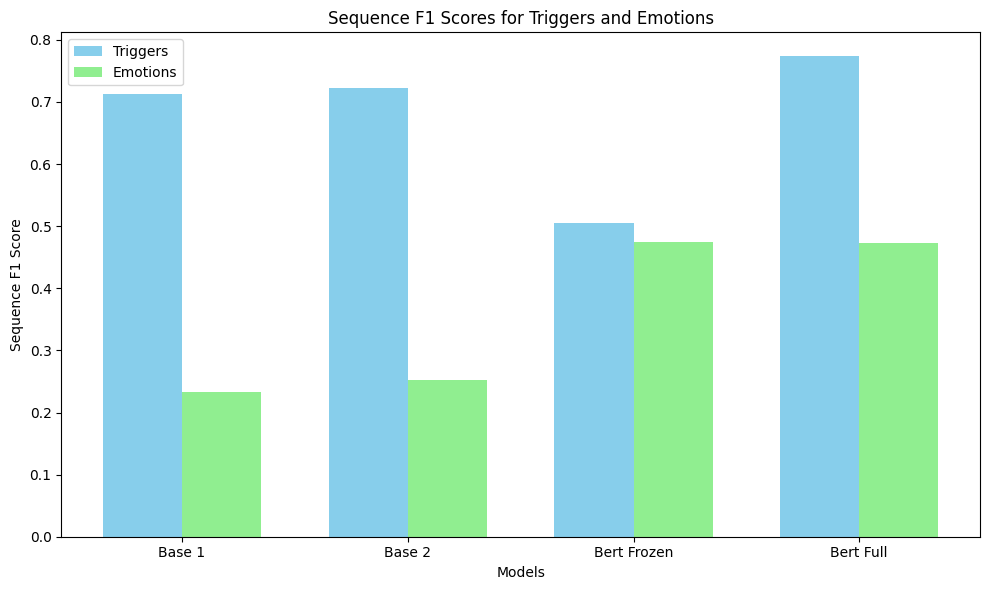

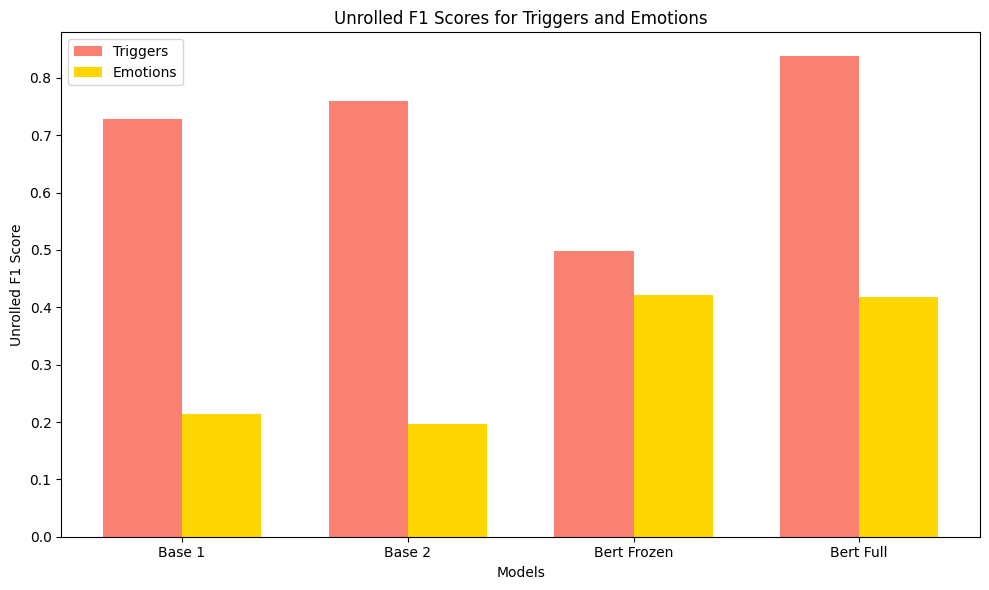

In [ ]:
models = ['Base 1', 'Base 2', 'Bert Frozen', 'Bert Full']
triggers_seq_f1 = [trigger_f1_seq_base1, trigger_f1_seq_base2, trigger_f1_seq_frozen, trigger_f1_seq_full]
emotions_seq_f1 = [emotion_f1_seq_base1, emotion_f1_seq_base2, emotion_f1_seq_frozen, emotion_f1_seq_full]
triggers_unrol_f1 = [trigger_f1_unrol_base1, trigger_f1_unrol_base2, trigger_f1_unrol_frozen, trigger_f1_unrol_full]
emotions_unrol_f1 = [emotion_f1_unrol_base1, emotion_f1_unrol_base2, emotion_f1_unrol_frozen, emotion_f1_unrol_full]

# Define colors
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']
bar_width = 0.35
index = range(len(models))

# Plot sequence F1 scores
plt.figure(figsize=(10, 6))

plt.bar(index, triggers_seq_f1, bar_width, label='Triggers', color=colors[0])
plt.bar([i + bar_width for i in index], emotions_seq_f1, bar_width, label='Emotions', color=colors[1])

plt.xlabel('Models')
plt.ylabel('Sequence F1 Score')
plt.title('Sequence F1 Scores for Triggers and Emotions')
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(10, 6))

plt.bar(index, triggers_unrol_f1, bar_width, label='Triggers', color=colors[2])
plt.bar([i + bar_width for i in index], emotions_unrol_f1, bar_width, label='Emotions', color=colors[3])

plt.xlabel('Models')
plt.ylabel('Unrolled F1 Score')
plt.title('Unrolled F1 Scores for Triggers and Emotions')
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend()

plt.tight_layout()
plt.show()

###Classification report

In [ ]:
def calculate_report(labels, predictions ,threshold):

       #Triggers
       y_true_tri = np.concatenate(labels[0])
       y_pred_tri = np.concatenate(predictions[0])

       y_pred_tri = y_pred_tri[y_true_tri != -1]
       y_true_tri = y_true_tri[y_true_tri != -1]

       y_pred_tri[y_pred_tri <=  threshold] = 0
       y_pred_tri[y_pred_tri >  threshold] = 1
       score_triggers = classification_report(y_true_tri, y_pred_tri, zero_division=0)

       #Emotions

       y_true_emo = np.concatenate(labels[1])
       y_pred_emo = np.concatenate(predictions[1])


       y_pred_emo = y_pred_emo[y_true_emo != -1]
       y_true_emo = y_true_emo[y_true_emo != -1]

       y_pred_emo = y_pred_emo.reshape(int(len(y_pred_emo)/num_classes),num_classes)
       y_true_emo = y_true_emo.reshape(int(len(y_true_emo)/num_classes),num_classes)

       score_emo = classification_report(np.argmax(y_true_emo, axis=1), np.argmax(y_pred_emo, axis=1), zero_division=0)
       f1_list_emotion = f1_score(np.argmax(y_true_emo, axis=1), np.argmax(y_pred_emo, axis=1), average = None)

       return score_triggers, score_emo, f1_list_emotion

def report_bert(labels, predictions, threshold):

     y_true_tri = np.concatenate(labels[0])
     y_pred_tri = np.concatenate(predictions[:, :24])

     y_pred_tri = y_pred_tri[y_true_tri != -1]
     y_true_tri = y_true_tri[y_true_tri != -1]

     y_pred_tri[y_pred_tri <=  threshold] = 0
     y_pred_tri[y_pred_tri >  threshold] = 1

     score_triggers = classification_report(y_true_tri, y_pred_tri, zero_division=0)


     y_true_emo = np.concatenate(labels[1])
     y_pred_emo = np.concatenate(predictions[:, 24:])

     y_pred_emo = y_pred_emo[y_true_emo != -1]
     y_true_emo = y_true_emo[y_true_emo != -1]

     y_pred_emo = y_pred_emo.reshape(int(len(y_pred_emo)/num_classes),num_classes)
     y_true_emo = y_true_emo.reshape(int(len(y_true_emo)/num_classes),num_classes)

     score_emo = classification_report(np.argmax(y_true_emo, axis=1), np.argmax(y_pred_emo, axis=1), zero_division=0)
     f1_list_emotion = f1_score(np.argmax(y_true_emo, axis=1), np.argmax(y_pred_emo, axis=1), average = None)

     return score_triggers, score_emo, f1_list_emotion



In [ ]:
score_triggers_random, score_emo_random, f1_list_random_emo = calculate_report(labels_b1, predictions_b1, optimal_threshold_base1)
score_triggers_majority, score_emo_majority, f1_list_majority_emo = calculate_report(labels_b2, predictions_b2, optimal_threshold_base2)


print("Random classifier for Triggers: \n")
print(score_triggers_random)
print("-------------------------------------------------------")

print("Random classifier for Emotions: \n")
print(score_emo_random)
print("-------------------------------------------------------")

print("Majority classifier for Triggers: \n")
print(score_triggers_majority)
print("-------------------------------------------------------")

print("Majority classifier for Emotions: \n")
print(score_emo_majority)
print("-------------------------------------------------------")

Random classifier for Triggers: 

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      2970
         1.0       0.17      0.20      0.18       545

    accuracy                           0.73      3515
   macro avg       0.51      0.51      0.51      3515
weighted avg       0.74      0.73      0.74      3515

-------------------------------------------------------
Random classifier for Emotions: 

              precision    recall  f1-score   support

           0       0.09      0.33      0.14       352
           1       0.02      0.03      0.02        71
           2       0.03      0.03      0.03        66
           3       0.18      0.13      0.15       644
           4       0.45      0.30      0.36      1624
           5       0.10      0.05      0.07       330
           6       0.12      0.10      0.11       428

    accuracy                           0.21      3515
   macro avg       0.14      0.14      0.13      3515
weighte

In [ ]:
score_triggers_frozen, score_emo_frozen, f1_list_frozen_emo = report_bert(test_prediction_info_frozen.label_ids, test_prediction_info_frozen.predictions, optimal_threshold_frozen)
score_triggers_full, score_emo_full, f1_list_full_emo = report_bert(test_prediction_info_full.label_ids, test_prediction_info_full.predictions, optimal_threshold_full)

print("Frozen Bert for Triggers: \n")
print(score_triggers_frozen)
print("-------------------------------------------------------")

print("Frozen Bert for Emotions: \n")
print(score_emo_frozen)
print("-------------------------------------------------------")

print("Full Bert for Triggers: \n")
print(score_triggers_full)
print("-------------------------------------------------------")

print("Full Bert for Emotions: \n")
print(score_emo_full)
print("-------------------------------------------------------")

Frozen Bert for Triggers: 

              precision    recall  f1-score   support

         0.0       0.85      0.49      0.62      2970
         1.0       0.16      0.55      0.25       545

    accuracy                           0.50      3515
   macro avg       0.51      0.52      0.44      3515
weighted avg       0.75      0.50      0.56      3515

-------------------------------------------------------
Frozen Bert for Emotions: 

              precision    recall  f1-score   support

           0       0.10      0.02      0.04       352
           1       0.02      0.01      0.02        71
           2       0.13      0.09      0.11        66
           3       0.21      0.02      0.04       644
           4       0.46      0.88      0.61      1624
           5       0.06      0.01      0.01       330
           6       0.11      0.03      0.05       428

    accuracy                           0.42      3515
   macro avg       0.16      0.15      0.12      3515
weighted avg       

We can plot the class-wise f1 scores of emotions for all models to understand the performance better

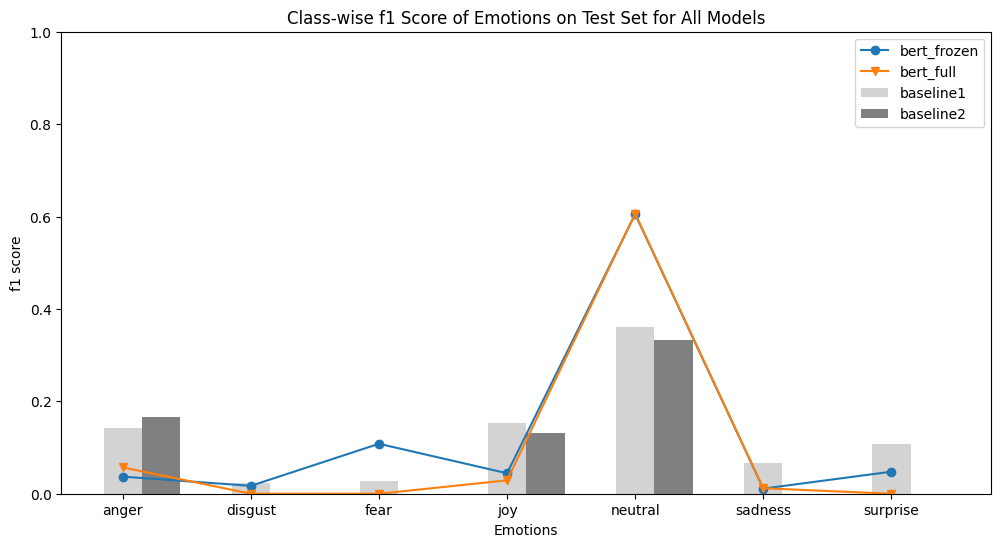

In [ ]:
plt.figure(figsize=(12,6))

X_axis = np.arange(7)

# Plot the bar chart
plt.plot(X_axis, f1_list_frozen_emo, '-o', label = 'bert_frozen')
plt.plot(X_axis, f1_list_full_emo, '-v', label = 'bert_full')
plt.bar(X_axis, f1_list_random_emo, 0.3, label='baseline1', color = 'lightgrey')
plt.bar(X_axis + 0.3, f1_list_majority_emo, 0.3, label='baseline2', color = 'grey')

plt.xticks(X_axis, label_encoder.classes_)
plt.xlabel("Emotions")
plt.ylim(0, 1)
plt.ylabel("f1 score")
plt.title("Class-wise f1 Score of Emotions on Test Set for All Models")
plt.legend()
plt.show()

###Confusion Matrix

In [ ]:
def conf_matrix(labels, predictions, threshold):

     y_true_tri = np.concatenate(labels[0])
     y_pred_tri = np.concatenate(predictions[:, :24])

     y_pred_tri = y_pred_tri[y_true_tri != -1]
     y_true_tri = y_true_tri[y_true_tri != -1]

     y_pred_tri[y_pred_tri <=  threshold] = 0
     y_pred_tri[y_pred_tri >  threshold] = 1

     conf_matrix_tri = confusion_matrix(y_true_tri, y_pred_tri)


     y_true_emo = np.concatenate(labels[1])
     y_pred_emo = np.concatenate(predictions[:, 24:])

     y_pred_emo = y_pred_emo[y_true_emo != -1]
     y_true_emo = y_true_emo[y_true_emo != -1]

     y_pred_emo = y_pred_emo.reshape(int(len(y_pred_emo)/num_classes),num_classes)
     y_true_emo = y_true_emo.reshape(int(len(y_true_emo)/num_classes),num_classes)

     conf_matrix_emo = confusion_matrix(np.argmax(y_true_emo, axis=1), np.argmax(y_pred_emo, axis=1))

     return conf_matrix_tri, conf_matrix_emo


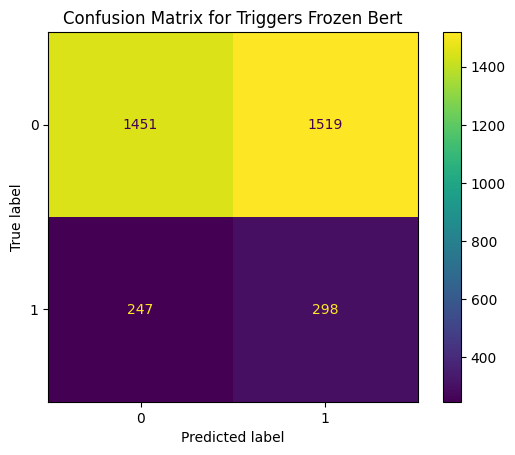

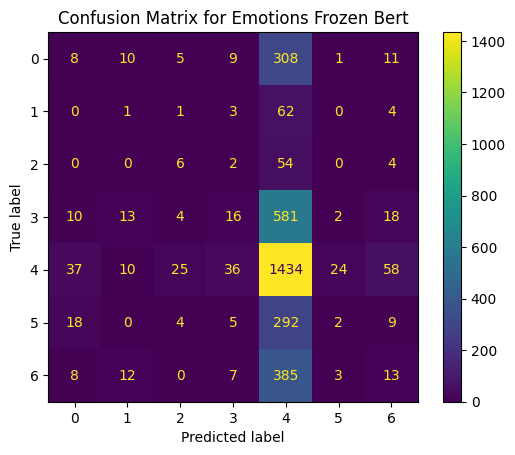

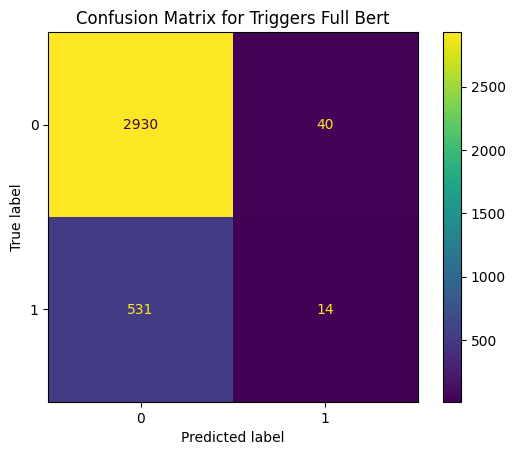

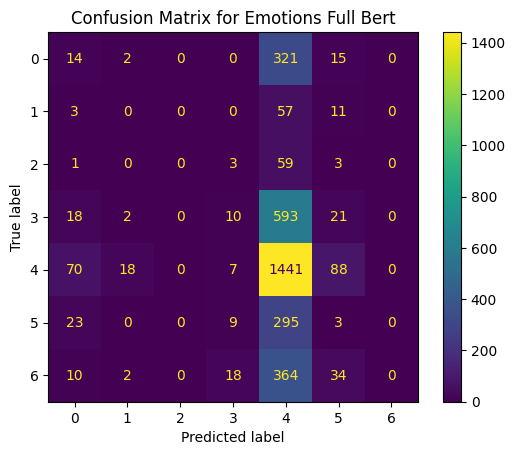

In [ ]:
conf_matrix_tri_frozen, conf_matrix_emo_frozen = conf_matrix(test_prediction_info_frozen.label_ids, test_prediction_info_frozen.predictions, optimal_threshold_frozen)
conf_matrix_tri_full, conf_matrix_emo_full = conf_matrix(test_prediction_info_full.label_ids, test_prediction_info_full.predictions, optimal_threshold_full)


disp = ConfusionMatrixDisplay(conf_matrix_tri_frozen)
disp.plot()
plt.title("Confusion Matrix for Triggers Frozen Bert")
plt.show()
print()

disp = ConfusionMatrixDisplay(conf_matrix_emo_frozen)
disp.plot()
plt.title("Confusion Matrix for Emotions Frozen Bert")
plt.show()
print()

disp = ConfusionMatrixDisplay(conf_matrix_tri_full)
disp.plot()
plt.title("Confusion Matrix for Triggers Full Bert")
plt.show()
print()

disp = ConfusionMatrixDisplay(conf_matrix_emo_full)
disp.plot()
plt.title("Confusion Matrix for Emotions Full Bert")
plt.show()


Let's also plot the distribution of sequence f1 scores for both models to observe the improvement better.

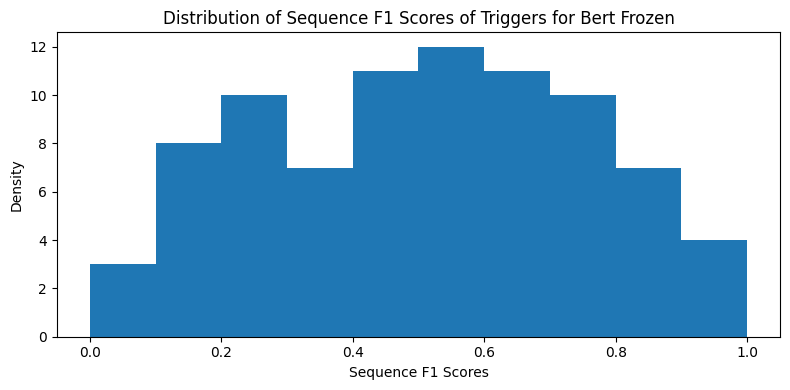

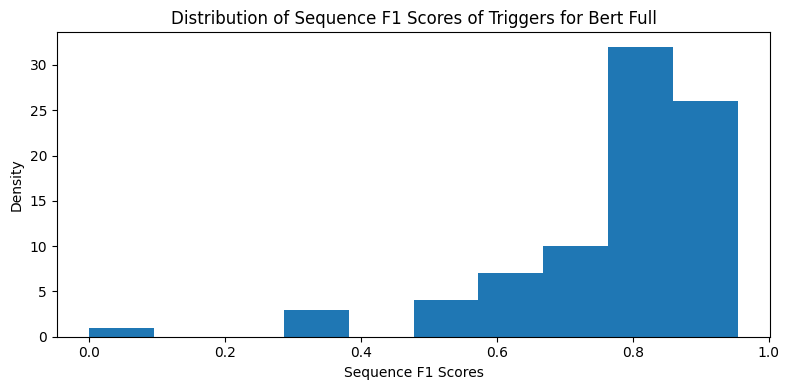

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(trigger_f1_seq_frozen_arr)
plt.xlabel('Sequence F1 Scores')
plt.ylabel('Density')
plt.title('Distribution of Sequence F1 Scores of Triggers for Bert Frozen')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(trigger_f1_seq_full_arr)
plt.xlabel('Sequence F1 Scores')
plt.ylabel('Density')
plt.title('Distribution of Sequence F1 Scores of Triggers for Bert Full')
plt.tight_layout()
plt.show()

As we can see from the graphs, f1 scores improve significantly for Triggers when the model is fine-tuned.

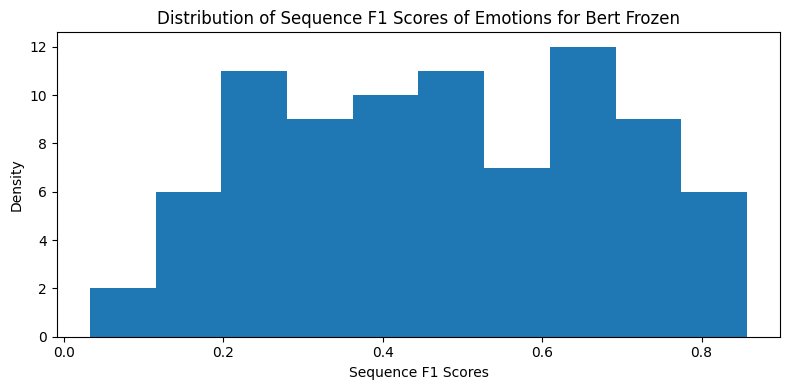

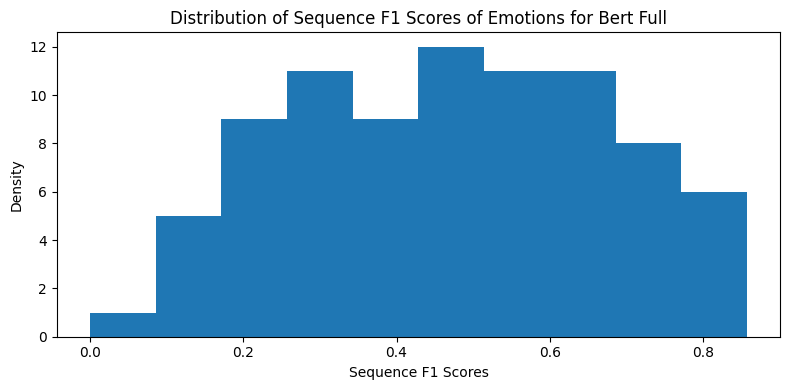

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(emotion_f1_seq_frozen_arr)
plt.xlabel('Sequence F1 Scores')
plt.ylabel('Density')
plt.title('Distribution of Sequence F1 Scores of Emotions for Bert Frozen')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(emotion_f1_seq_full_arr)
plt.xlabel('Sequence F1 Scores')
plt.ylabel('Density')
plt.title('Distribution of Sequence F1 Scores of Emotions for Bert Full')
plt.tight_layout()
plt.show()

Unlike Triggers, fine-tuning doesn't improve f1 scores for the emotions.

Let's check if there is any correlation between the f1 scores and dialogue length

In [ ]:
unique_dialogs = list({value:"" for value in test_df['dialogue_id']})
list_len = []
i=0
for dialog_id in unique_dialogs:
    num_concat = len(test_df[test_df['dialogue_id'] == dialog_id])

    dialogue = np.concatenate(test_df['utterances'][i:i+num_concat])
    list_len.append(len(dialogue))

Correlation coefficient between dialogue lengths and F1 scores of Triggers: 0.30869633476132025


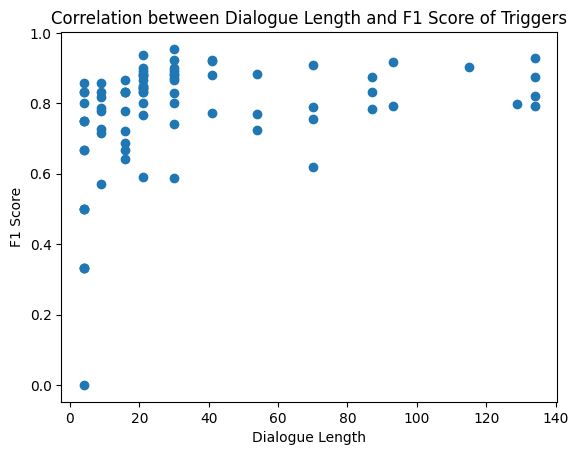

In [ ]:
list_of_tuples = list(zip(trigger_f1_seq_full_arr, list_len))

# Converting lists of tuples into
# pandas Dataframe.
data = pd.DataFrame(list_of_tuples,
                  columns=['F1_Score', 'Dialogue_Length'])

correlation = data['Dialogue_Length'].corr(data['F1_Score'])

print(f"Correlation coefficient between dialogue lengths and F1 scores of Triggers: {correlation}")

# Create a scatter plot to visualize the relationship between dialogue lengths and F1 scores
plt.scatter(data['Dialogue_Length'], data['F1_Score'])
plt.xlabel('Dialogue Length')
plt.ylabel('F1 Score')
plt.title('Correlation between Dialogue Length and F1 Score of Triggers')
plt.show()

Correlation coefficient between dialogue lengths and F1 scores of Emotions: -0.34359369306526083


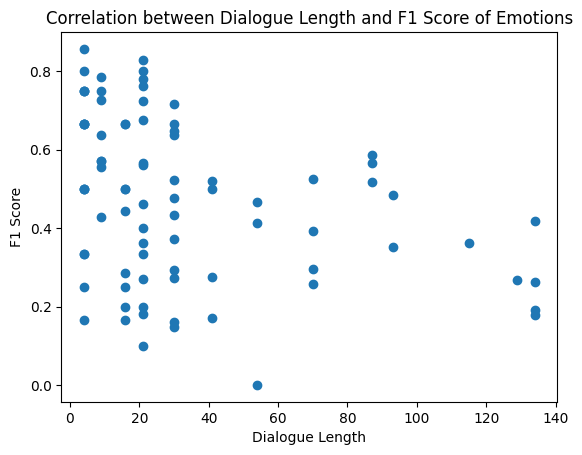

In [ ]:
list_of_tuples = list(zip(emotion_f1_seq_full_arr, list_len))

# Converting lists of tuples into
# pandas Dataframe.
data = pd.DataFrame(list_of_tuples,
                  columns=['F1_Score', 'Dialogue_Length'])

correlation = data['Dialogue_Length'].corr(data['F1_Score'])

print(f"Correlation coefficient between dialogue lengths and F1 scores of Emotions: {correlation}")

# Create a scatter plot to visualize the relationship between dialogue lengths and F1 scores
plt.scatter(data['Dialogue_Length'], data['F1_Score'])
plt.xlabel('Dialogue Length')
plt.ylabel('F1 Score')
plt.title('Correlation between Dialogue Length and F1 Score of Emotions')
plt.show()

Finally, we can analyze some specific examples with low f1 score

In [ ]:
trigger_ex_df_min = test_df[test_df['dialogue_id']==unique_dialogs[trigger_f1_seq_full_arr.index(min(trigger_f1_seq_full_arr))]][['speakers','utterances','emotions','triggers']].tail(1)

trigger_ex_min = test_prediction_info_full.predictions[:, :24][trigger_ex_df_min.index[0]]
trigger_ex_min[trigger_ex_min <= optimal_threshold_full] = 0
trigger_ex_min[trigger_ex_min > optimal_threshold_full] = 1
trigger_ex_df_min['triggers_pred_full'] = [trigger_ex_min[0:len(list(trigger_ex_df_min['triggers'])[0])]]

trigger_ex_min2 = test_prediction_info_frozen.predictions[:, :24][trigger_ex_df_min.index[0]]
trigger_ex_min2[trigger_ex_min2 <= optimal_threshold_frozen] = 0
trigger_ex_min[trigger_ex_min2 > optimal_threshold_frozen] = 1
trigger_ex_df_min['triggers_pred_frozen'] = [trigger_ex_min2[0:len(list(trigger_ex_df_min['triggers'])[0])]]

In [ ]:
print("A specific dialogue which the f1 score of Triggers is :", min(trigger_f1_seq_full_arr))
print("-------------------------------------------------------")
trigger_ex_df_min.apply(pd.Series.explode)

A specific dialogue which the f1 score of Triggers is : 0.0
-------------------------------------------------------


,speakers,utterances,emotions,triggers,triggers_pred_full,triggers_pred_frozen
224,Phoebe,"Hey you guys, guess what?",neutral,1.0,0.0,0.0
224,Chandler,The British are coming?,neutral,1.0,0.0,0.0
224,Phoebe,"Ohh, you and your ways. Since it's Christmast...",joy,1.0,0.0,0.0


In [ ]:
trigger_ex_df_max = test_df[test_df['dialogue_id']==unique_dialogs[trigger_f1_seq_full_arr.index(max(trigger_f1_seq_full_arr))]][['speakers','utterances','emotions','triggers']].tail(1)

trigger_ex_max = test_prediction_info_full.predictions[:, :24][trigger_ex_df_max.index[0]]
trigger_ex_max[trigger_ex_max <= optimal_threshold_full] = 0
trigger_ex_max[trigger_ex_max > optimal_threshold_full] = 1
trigger_ex_df_max['triggers_pred_full'] = [trigger_ex_max[0:len(list(trigger_ex_df_max['triggers'])[0])]]

trigger_ex_max2 = test_prediction_info_frozen.predictions[:, :24][trigger_ex_df_max.index[0]]
trigger_ex_max2[trigger_ex_max2 <= optimal_threshold_frozen] = 0
trigger_ex_max2[trigger_ex_max2 > optimal_threshold_frozen] = 1
trigger_ex_df_max['triggers_pred_frozen'] = [trigger_ex_max2[0:len(list(trigger_ex_df_max['triggers'])[0])]]

In [ ]:
print("A specific dialogue which the f1 score of Triggers for Bert Full is :", max(trigger_f1_seq_full_arr))
print("-------------------------------------------------------")
trigger_ex_df_max.apply(pd.Series.explode)

A specific dialogue which the f1 score of Triggers for Bert Full is : 0.9545454545454546
-------------------------------------------------------


,speakers,utterances,emotions,triggers,triggers_pred_full,triggers_pred_frozen
121,Phoebe,Hi.,neutral,0.0,0.0,0.0
121,Monica,Hi!,anger,0.0,0.0,0.0
121,All,Hey!,joy,0.0,0.0,1.0
121,Joey,"Uh, Pheebs, about your mom...",neutral,0.0,0.0,1.0
121,Phoebe,Yeah?,surprise,0.0,0.0,1.0
121,Joey,How's that going?,neutral,0.0,0.0,1.0
121,Phoebe,"So great. Oh, we took a nap today and my Mom f...",joy,0.0,0.0,1.0
121,Joey,That's so sweet. I'm gonna get some coffee.,neutral,0.0,0.0,0.0
121,Monica,Huh? What'd ya say Joe? I'll be right there.,surprise,0.0,0.0,0.0
121,Rachel,Pheebs...,neutral,0.0,0.0,0.0


Unlike Bert frozen, Bert full predicts all samples for this dialogue correctly but again this correct label is the dominant one in our dataset. So rather than learning the difference between trigger and non-trigger samples, fine-tuning makes our model more bias towards the most represented class

In [ ]:
emotion_ex_df_min = test_df[test_df['dialogue_id']==unique_dialogs[emotion_f1_seq_full_arr.index(min(emotion_f1_seq_full_arr))]][['speakers','utterances','triggers','emotions']].tail(1)

emotion_ex_min = test_prediction_info_full.predictions[:, 24:][emotion_ex_df_min.index[0]]
emotion_ex_min  = emotion_ex_min[test_prediction_info_full.label_ids[1][emotion_ex_df_min.index[0]] != -1]
emotion_ex_pred_min = emotion_ex_min.reshape(int(len(emotion_ex_min)/num_classes),num_classes)
emotion_ex_df_flat_min = emotion_ex_df_min.apply(pd.Series.explode)
emotion_ex_df_flat_min['emotions_pred_full'] = label_encoder.inverse_transform(np.argmax(emotion_ex_pred_min, axis=1)).tolist()

emotion_ex_min2 = test_prediction_info_frozen.predictions[:, 24:][emotion_ex_df_min.index[0]]
emotion_ex_min2  = emotion_ex_min2[test_prediction_info_frozen.label_ids[1][emotion_ex_df_min.index[0]] != -1]
emotion_ex_pred_min2 = emotion_ex_min2.reshape(int(len(emotion_ex_min2)/num_classes),num_classes)
emotion_ex_df_flat_min['emotions_pred_frozen'] = label_encoder.inverse_transform(np.argmax(emotion_ex_pred_min2, axis=1)).tolist()

In [ ]:
print("A specific dialogue which the f1 score of Emotions for Bert Full is :", min(emotion_f1_seq_full_arr))
print("-------------------------------------------------------")
emotion_ex_df_flat_min

A specific dialogue which the f1 score of Emotions for Bert Full is : 0.0
-------------------------------------------------------


,speakers,utterances,triggers,emotions,emotions_pred_full,emotions_pred_frozen
214,Ross,is for me not to see you anymore.,0.0,sadness,neutral,neutral
214,Rachel,That's crazy!,0.0,surprise,neutral,neutral
214,Rachel,You can't do that!,0.0,surprise,neutral,neutral
214,Rachel,What are you going to tell her?,0.0,sadness,neutral,neutral
214,Rachel,Oh God.,0.0,fear,neutral,neutral
214,Rachel,"Ohh, you already agreed to this, haven't you?",0.0,sadness,neutral,neutral
214,Ross,"It's awful I know, I mean, I feel terrible but...",0.0,sadness,neutral,neutral
214,Ross,"And I do, I have to make",0.0,sadness,neutral,neutral
214,Rachel,Ohh! Lucky me! Oh my God! That,0.0,surprise,neutral,neutral
214,Ross,You have no idea what a nightmare this has bee...,0.0,sadness,neutral,neutral


As it is seen, Bert full predicts all emotions wrong for this specific dialogue whereas Bert frozen predicts one label correctly which is surprise showing that fine-tuning does not offer any improvement

In [ ]:
emotion_ex_df_max = test_df[test_df['dialogue_id']==unique_dialogs[emotion_f1_seq_full_arr.index(max(emotion_f1_seq_full_arr))]][['speakers','utterances','triggers','emotions']].tail(1)

emotion_ex_max = test_prediction_info_full.predictions[:, 24:][emotion_ex_df_max.index[0]]
emotion_ex_max  = emotion_ex_max[test_prediction_info_full.label_ids[1][emotion_ex_df_max.index[0]] != -1]
emotion_ex_pred_max = emotion_ex_max.reshape(int(len(emotion_ex_max)/num_classes),num_classes)
emotion_ex_df_flat_max = emotion_ex_df_max.apply(pd.Series.explode)
emotion_ex_df_flat_max['emotions_pred_full'] = label_encoder.inverse_transform(np.argmax(emotion_ex_pred_max, axis=1)).tolist()

emotion_ex_max2 = test_prediction_info_frozen.predictions[:, 24:][emotion_ex_df_max.index[0]]
emotion_ex_max2 = emotion_ex_max2[test_prediction_info_frozen.label_ids[1][emotion_ex_df_max.index[0]] != -1]
emotion_ex_pred_max2 = emotion_ex_max2.reshape(int(len(emotion_ex_max2)/num_classes),num_classes)
emotion_ex_df_flat_max['emotions_pred_frozen'] = label_encoder.inverse_transform(np.argmax(emotion_ex_pred_max2, axis=1)).tolist()

In [ ]:
print("A specific dialogue which the f1 score of Emotions for Bert Full is :", max(emotion_f1_seq_full_arr))
print("-------------------------------------------------------")
emotion_ex_df_flat_max

A specific dialogue which the f1 score of Emotions for Bert Full is : 0.8571428571428571
-------------------------------------------------------


,speakers,utterances,triggers,emotions,emotions_pred_full,emotions_pred_frozen
207,Joey,Bijan for men?,0.0,neutral,neutral,neutral
207,Joey,Bijan for men?,0.0,neutral,neutral,neutral
207,Joey,"Bijan for... Hey, Annabelle, Uh, listen, I w...",0.0,neutral,neutral,neutral
207,Annabelle,"Oh, actually I sorta have plans.",0.0,neutral,neutral,neutral
207,Hombre Man,"Ready, Annabelle?",0.0,neutral,neutral,neutral
207,Annabelle,You bet. Maybe some other time?,1.0,neutral,neutral,neutral
207,Joey,"Hey, it's not the first time I lost a girl to ...",0.0,sadness,neutral,neutral


Here, both models predict labels as most presented class which is neutral and since we have a high number of neutral samples in this specific dialogue, the f1 score is high